In [67]:
import pandas as pd
import openpyxl as op
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pprint import pprint
from tabulate import tabulate

In [68]:
basesota = pd.read_excel("BCvsBL_DEGppython.xlsx") #Tesis/
basesota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   160 non-null    int64  
 1   gen          160 non-null    object 
 2   base_mean    160 non-null    float64
 3   log2fc       160 non-null    float64
 4   geneproduct  160 non-null    object 
 5   cepa         160 non-null    object 
 6   dia          160 non-null    object 
 7   ref_comp     160 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.1+ KB


In [69]:
display(basesota)

,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp
0,1,gene-BJM02_19040,1.027724,1.961887,NDP-hexose 4-ketoreductase,BC,D14,bcd14vsbld14
1,2,gene-BJM02_10680,0.883584,1.808230,hypothetical protein,BC,D14,bcd14vsbld14
2,3,gene-BJM02_02420,0.862903,1.780877,3-hydroxybutyryl-CoA dehydrogenase,BC,D14,bcd14vsbld14
3,4,gene-BJM02_20260,0.732278,1.514593,polyketide synthase,BC,D14,bcd14vsbld14
4,5,gene-BJM02_03580,0.710328,1.505496,translation elongation factor Tu,BC,D14,bcd14vsbld14
...,...,...,...,...,...,...,...,...
155,156,gene-BJM02_11095,0.458044,0.176259,hypothetical protein,BL,D28,bld14vsbld28
156,157,gene-BJM02_17045,0.799127,0.163857,WhiB family transcriptional regulator,BL,D28,bld14vsbld28
157,158,gene-BJM02_02415,3.217883,0.139740,isocitrate lyase,BL,D28,bld14vsbld28
158,159,gene-BJM02_05700,0.234589,0.131667,acetyl-CoA acetyltransferase,BL,D28,bld14vsbld28


Se cargó la base de datos. El objetivo es clasificar las proteínas por grupo y por subgrupo. 

Paso 1: generar la variable con los grupos. Obtenida de la var en R

Paso 2: hacer el loop de estandarizacion de valores

Paso 3: Loop de reemplazo. 

Paso 4: Guardar como nuevo excel. 

In [70]:
#Variable con los grupos
proteinas_metabolicas = ["NDP-hexose 4-ketoreductase", "Phosphoenolpyruvate carboxykinase", "Trehalose-phosphatase", #metabolismo de carbohidratos
"Polyketide synthase", "Diacylglycerol acyltransferase/mycolyltransferase Ag85A", 
"Diacylglycerol O-acyltransferase", "3-oxoacyl-ACP synthase", #Metabolismo lípidos
"Pyruvate dehydrogenase (acetyl-transferring) E1 component subunit alpha", "Isocitrate lyase", "Alpha-hydroxy-acid oxidizing enzyme", "2-methylcitrate synthase", #metabolismo central
"Biotin synthase BioB", "Cysteine dioxygenase",   #coenzimas y cofactores
"3-hydroxybutyryl-CoA dehydrogenase", "Acetyl-CoA acetyltransferase", "Amidophosphoribosyltransferase"] #Nucleotidosyaminoacidos
proteinas_secrecion = ["Type VII secretion-associated serine protease mycosin", "Type VII secretion protein EccB", "Type VII secretion AAA-ATPase EccA", "Type VII secretion protein EsxI"]
proteinas_transcripcion_traduccion = ["Signal peptidase II", "Translation elongation factor Tu", "Elongation factor G",           
                                         "50S ribosomal protein L3", "5S ribosomal RNA", "DNA-directed RNA polymerase subunit beta"] #traduccion
proteinas_adaptoras_estres = ["ATP-dependent protease ATP-binding subunit ClpX", "Chaperonin GroL", "ATP-dependent Clp protease proteolytic subunit", "Universal stress protein"]
#proteinas_alteracion_epigenomica = ["SAM-dependent methyltransferase"]
#proteinas_intercalante_fagolisosomal = ["Penicillin-binding protein"]
#proteinas_sideroforo = ["Fe-S cluster assembly protein SufB"]
proteinas_regulador_transcripcional = ["Transcriptional regulator, LytR family protein",
                                           "WhiB family transcriptional regulator",
                                           "TetR family transcriptional regulator"
]
proteinas_rna_o_procesamiento = ["RNase P RNA component class A", "Transfer-messenger RNA"]
#proteinas_lipidos = ["Bacterioferritin"]
#proteinas_transposasa = ["IS256 family transposase"]

#modificado para incluir proteinas no incluidas. 
proteinas_metabolicas.extend([
    "adenosylhomocysteinase", "Bacterioferritin", "Fe-S cluster assembly protein SufB", # Cofactor metabolism
    "2c8_didemethyl_8_hydroxy_5_deazariboflavin_synthase", # Cofactor biosynthesis
    "Penicillin-binding protein" #lípidos paredes
])

proteinas_transcripcion_traduccion.extend([
    "transcriptional_regulator%2c_lytr_family_protein", # Transcriptional regulation
    "50s_ribosomal_protein_l13", "IS256 family transposase", 
    "adenylyltransferase/sulfurtransferase_moez", "SAM-dependent methyltransferase" # alteración epigenómica
])

#proteinas_alteracion_epigenomica.extend([
#    "adenylyltransferase/sulfurtransferase_moez" # Likely epigenomic regulation
#])

proteinas_adaptoras_estres.extend([
    "chad_domain_containing_protein", # Stress response
    "anion_permeasa"                 # Adaptation to ion stress
])

proteinas_regulador_transcripcional.extend([
    "pe_family_protein" # Possible regulatory role
])

# Exclude hypothetical proteins
proteinas_hipoteticas = [
    "hypothetical_protein",
    "hypothetical_proteins"
]

# Keep non-classifiable proteins in a separate list for potential future use
otras = [
    "duf2334_domain_containing_protein"  # Domain-specific, unclassified
]
#, , proteinas_alteracion_epigenomica, proteinas_sideroforo,
grupos_prote = [proteinas_metabolicas, proteinas_secrecion, proteinas_transcripcion_traduccion, proteinas_adaptoras_estres, proteinas_regulador_transcripcional, proteinas_rna_o_procesamiento, proteinas_hipoteticas, otras]
print(tabulate(grupos_prote))


-----------------------------------------------------  -------------------------------------  ----------------------------------------------  -------------------------------  -------------------------------------------------------  ----------------------------------------  ------------------------------------------------  -----------------------------------------------------------------------  ------------------------  ------------------------------------------  -------------------------------  --------------------  --------------------  ----------------------------------  ----------------------------  ------------------------------  ----------------------  ----------------  ----------------------------------  ---------------------------------------------------  --------------------------
NDP-hexose 4-ketoreductase                             Phosphoenolpyruvate carboxykinase      Trehalose-phosphatase                           Polyketide synthase              Diacylglycerol acyltransf

Aqui supuestamente tengo los grupos totales que deben de estar en la columna geneproduct de basesota. 

In [71]:
#Paso 2:Hacer el loop de estandarización de valores
#fragmentos a estandarizar
#1
basesota["geneproduct"] = basesota["geneproduct"].str.strip().str.lower().str.replace("-", "_").str.replace(" ", "_")
#listo estandarizado todo a snake_case sin espacios y en minuscula

#2 grupos_prote
for i, grupo in enumerate(grupos_prote):
    for j, elemento in enumerate(grupo):
        grupos_prote[i][j] = elemento.strip().lower().replace("-", "_").replace(" ", "_")
        
print(basesota["geneproduct"]) #listo estandarizado. 
print(tabulate(grupos_prote))


#Necesito un diccionario en lugar de una lista de listas 
#"proteinas_intercalante_fagolisosomal":grupos_prote[5]. "proteinas_lipidos":grupos_prote[9],
#[proteinas_metabolicas, proteinas_secrecion, proteinas_transcripcion_traduccion, proteinas_adaptoras_estres, proteinas_alteracion_epigenomica,  proteinas_intercalante_fagolisosomal, 
#                     proteinas_sideroforo, proteinas_regulador_transcripcional, proteinas_rna_o_procesamiento, proteinas_lipidos, proteinas_transposasa, proteinas_hipoteticas, otras]
#"proteinas_intercalante_fagolisosomal": grupos_prote[5], "proteinas_lipidos":grupos_prote[9], "proteinas_transposasa":grupos_prote[10],  "proteinas_alteracion_epigenomica":grupos_prote[4], "proteinas_sideroforo":grupos_prote[5],
grupos_prote_dict = {
    "proteinas_metabolicas": grupos_prote[0], "proteinas_secrecion":grupos_prote[1], "proteinas_transcripcion_traduccion":grupos_prote[2], "proteinas_adaptoras_estres":grupos_prote[3], "proteinas_regulador_transcripcional":grupos_prote[4], "proteinas_rna_o_procesamiento":grupos_prote[5],  "proteinas_hipoteticas": grupos_prote[6], "otras":grupos_prote[7]}

print(grupos_prote_dict)

0                      ndp_hexose_4_ketoreductase
1                            hypothetical_protein
2              3_hydroxybutyryl_coa_dehydrogenase
3                             polyketide_synthase
4                translation_elongation_factor_tu
                          ...                    
155                          hypothetical_protein
156         whib_family_transcriptional_regulator
157                              isocitrate_lyase
158                  acetyl_coa_acetyltransferase
159    adenylyltransferase/sulfurtransferase_moez
Name: geneproduct, Length: 160, dtype: object
-----------------------------------------------------  -------------------------------------  ----------------------------------------------  -------------------------------  -------------------------------------------------------  ----------------------------------------  ------------------------------------------------  -----------------------------------------------------------------------  -------

In [72]:
basesota.info() #hizo una columna extra clasificacion. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   160 non-null    int64  
 1   gen          160 non-null    object 
 2   base_mean    160 non-null    float64
 3   log2fc       160 non-null    float64
 4   geneproduct  160 non-null    object 
 5   cepa         160 non-null    object 
 6   dia          160 non-null    object 
 7   ref_comp     160 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.1+ KB


In [73]:


#Paso de drop if hypothetical_protein #puede ser al momento de hacer los gráficos

#Paso 3:loop de reemplazo
#iterar sobre los grupos_prote[[]] y sobre basesota[geneproduct], asignar ese valor a basesota[clasificacion]
pendientes_a_clasificar = []
for group_name, group_values in grupos_prote_dict.items():
    for value in group_values:
        basesota.loc[basesota["geneproduct"]== value, "clasificacion"] = group_name
pendientes_a_clasificar = basesota[basesota["clasificacion"].isna()]["geneproduct"].tolist()

print(basesota["clasificacion"].isna().sum())
print(pendientes_a_clasificar)
    

0
[]


In [74]:
#basesota donde clasificacion es Na
na_basesota = basesota[basesota["clasificacion"].isna()] #no NA post modificar grupos.
display(na_basesota)

,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion


No hay elementos nulos en clasificación. 

In [75]:
print(na_basesota["geneproduct"].unique()) #solo 11- #tiene #añadidas a los grupos para involucrarse 
na_basesota["geneproduct"].nunique()

[]


0

In [76]:
display(basesota)

,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion
0,1,gene-BJM02_19040,1.027724,1.961887,ndp_hexose_4_ketoreductase,BC,D14,bcd14vsbld14,proteinas_metabolicas
1,2,gene-BJM02_10680,0.883584,1.808230,hypothetical_protein,BC,D14,bcd14vsbld14,proteinas_hipoteticas
2,3,gene-BJM02_02420,0.862903,1.780877,3_hydroxybutyryl_coa_dehydrogenase,BC,D14,bcd14vsbld14,proteinas_metabolicas
3,4,gene-BJM02_20260,0.732278,1.514593,polyketide_synthase,BC,D14,bcd14vsbld14,proteinas_metabolicas
4,5,gene-BJM02_03580,0.710328,1.505496,translation_elongation_factor_tu,BC,D14,bcd14vsbld14,proteinas_transcripcion_traduccion
...,...,...,...,...,...,...,...,...,...
155,156,gene-BJM02_11095,0.458044,0.176259,hypothetical_protein,BL,D28,bld14vsbld28,proteinas_hipoteticas
156,157,gene-BJM02_17045,0.799127,0.163857,whib_family_transcriptional_regulator,BL,D28,bld14vsbld28,proteinas_regulador_transcripcional
157,158,gene-BJM02_02415,3.217883,0.139740,isocitrate_lyase,BL,D28,bld14vsbld28,proteinas_metabolicas
158,159,gene-BJM02_05700,0.234589,0.131667,acetyl_coa_acetyltransferase,BL,D28,bld14vsbld28,proteinas_metabolicas


In [77]:
basesota.groupby(["cepa", "dia", "clasificacion"])["cepa"].count()

BL = basesota[basesota["cepa"]=="BL"]
BC = basesota[basesota["cepa"]=="BC"]

dia14 = BL[BL["dia"]== "D14"] #["geneproduct"]
dia28 = BL[BL["dia"]== "D28"] #["geneproduct"]
metabolicas_BLD14 = dia14[dia14["clasificacion"]=="proteinas_metabolicas"]["geneproduct"].sort_values()
metabolicas_BLD28 = dia28[dia28["clasificacion"]=="proteinas_metabolicas"]["geneproduct"].sort_values() #son las mismas
print(metabolicas_BLD14)
print(metabolicas_BLD28)
#print(BL)
#print(dia14)
#print(dia28)

dia14BC = BC[BC["dia"]=="D14"]
dia28BC = BC[BC["dia"]=="D28"]

metabolicas_BCD14 = dia14BC[dia14BC["clasificacion"]=="proteinas_metabolicas"]["geneproduct"].sort_values()
metabolicas_BCD28 = dia28BC[dia28BC["clasificacion"]=="proteinas_metabolicas"]["geneproduct"].sort_values() #son las mismas

print(metabolicas_BCD14)
print(metabolicas_BCD28) #hay 2 grupos comparativos que deben separarse. En todos los casos. Al día 28 se compara con la otra cepa y con la misma cepa del mismo día. Y ambas pueden generar resultados similares de expresión de grupos de proteínas. 







24                              2_methylcitrate_synthase
134    2c8_didemethyl_8_hydroxy_5_deazariboflavin_syn...
22                    3_hydroxybutyryl_coa_dehydrogenase
123                               3_oxoacyl_acp_synthase
38                          acetyl_coa_acetyltransferase
20                                adenosylhomocysteinase
129                       amidophosphoribosyltransferase
136                                     bacterioferritin
122    diacylglycerol_acyltransferase/mycolyltransfer...
133    diacylglycerol_acyltransferase/mycolyltransfer...
30                      diacylglycerol_o_acyltransferase
21                    fe_s_cluster_assembly_protein_sufb
37                                      isocitrate_lyase
138                           penicillin_binding_protein
127    pyruvate_dehydrogenase_(acetyl_transferring)_e...
28                                 trehalose_phosphatase
Name: geneproduct, dtype: object
144                             2_methylcitrate_synthas

In [78]:
#cuando se quiera exportar
basesota.to_excel("basecuradaMTb.xlsx", index=False, sheet_name="GenesDEG")
#basesota = pd.read_excel("Tesis/genesDEGMtb.xlsx")
#basesota.info()


In [79]:
basesota.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     160 non-null    int64  
 1   gen            160 non-null    object 
 2   base_mean      160 non-null    float64
 3   log2fc         160 non-null    float64
 4   geneproduct    160 non-null    object 
 5   cepa           160 non-null    object 
 6   dia            160 non-null    object 
 7   ref_comp       160 non-null    object 
 8   clasificacion  160 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 11.4+ KB


Si son las mismas las proteinas metabolicas en BLD14 y BLD28. Las demás también? 

In [80]:
#print(BL["clasificacion"].unique()) #'proteinas_metabolicas' 'proteinas_sideroforo' 'proteinas_secrecion'
# 'proteinas_rna_o_procesamiento' 'proteinas_hipoteticas'
# 'proteinas_transcripcion_traduccion' 'otras' 'proteinas_adaptoras_estres'
# 'proteinas_regulador_transcripcional' 'proteinas_alteracion_epigenomica'
# 'proteinas_transposasa' 'proteinas_lipidos'
# 'proteinas_intercalante_fagolisosomal'

estresoras_BLD14 = dia14[dia14["clasificacion"]=="proteinas_adaptoras_estres"]["geneproduct"].sort_values()
estresoras_BLD28 = dia28[dia28["clasificacion"]=="proteinas_adaptoras_estres"]["geneproduct"].sort_values() #son las mismas tmbn


#print(estresoras_BLD14) #las mismas
#print(estresoras_BLD28)

secrecion_BLD14 = dia14[dia14["clasificacion"]=="proteinas_secrecion"]["geneproduct"].sort_values()
secrecion_BLD28 = dia28[dia28["clasificacion"]=="proteinas_secrecion"]["geneproduct"].sort_values()

#print(secrecion_BLD14) #las mismas
#print(secrecion_BLD28)

#Comparar todas las clasificaciones para buscar diferencias
BLD14clas = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D14")]["clasificacion"].unique())
BLD28clas = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D28")]["clasificacion"].unique())
BLD14clasgp = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D14")]["geneproduct"].unique())
BLD28clasgp = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D28")]["geneproduct"].unique())

iguales = BLD14clas == BLD28clas
igualesgp = BLD14clasgp == BLD28clasgp

print(iguales) #exactamente iguales. mismas proteinas en distintas cantidades al menos por clasificacion
print(igualesgp) #exactamente los mismos genes. 

#Considerando solamente la comparación de BLD14 vs BLD28
BLD14clas_solo_blvsbl = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D14") & (basesota["ref_comp"]=="bld14vsbld28")]["clasificacion"].unique())
BLD28clas_solo_blvsbl = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D28")& (basesota["ref_comp"]=="bld14vsbld28")]["clasificacion"].unique())
BLD14clasgp_solo_blvsbl = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D14")& (basesota["ref_comp"]=="bld14vsbld28")]["geneproduct"].unique())
BLD28clasgp_solo_blvsbl = sorted(basesota[(basesota["cepa"]=="BL") & (basesota["dia"]=="D28")& (basesota["ref_comp"]=="bld14vsbld28")]["geneproduct"].unique())

iguales_solo_blvsbl = BLD14clas_solo_blvsbl == BLD28clas_solo_blvsbl
igualesgp_solo_blvsbl = BLD14clasgp_solo_blvsbl == BLD28clasgp_solo_blvsbl

print(iguales_solo_blvsbl) #No son las mismas al comparar BLd14 vs BLd28. Si son las mismas si se compara contra BC. 
print(igualesgp_solo_blvsbl) #se tiene que rehacer el pie. Para comparar solo bc vs bl y bl vs bl. 
#Lo que estaba pasando era que bld14 vs bc y bld28 vs bc si son los mismos grupos.


True
True
False
False


Se hará un contraste en gráficos de barras entre los promedios por cepa por día por gen sobreexpresado #otro con log2fc?

Paso 1: Aislar los datos por cepa por día considerando solo por comparaciones similares. Cepa BLD14 vs Cepa BLD28 cuando se comparan entre ellas. 

Paso 2: Graficar en barra los elementos relevantes. Eje X = genes, eje Y = promedios. 

In [81]:
#Revisar marco de datos de donde se sacarán los datos

display(BL)
print(BL.info())
display(BC)
print(BC.info())

,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion
20,21,gene-BJM02_17200,0.627258,1.325954,adenosylhomocysteinase,BL,D14,bcd14vsbld14,proteinas_metabolicas
21,22,gene-BJM02_07780,1.248599,0.879217,fe_s_cluster_assembly_protein_sufb,BL,D14,bcd14vsbld14,proteinas_metabolicas
22,23,gene-BJM02_02420,0.371430,0.704865,3_hydroxybutyryl_coa_dehydrogenase,BL,D14,bcd14vsbld14,proteinas_metabolicas
23,24,gene-BJM02_01490,0.650641,0.563214,type_vii_secretion_aaa_atpase_ecca,BL,D14,bcd14vsbld14,proteinas_secrecion
24,25,gene-BJM02_06005,0.267520,0.559705,2_methylcitrate_synthase,BL,D14,bcd14vsbld14,proteinas_metabolicas
...,...,...,...,...,...,...,...,...,...
155,156,gene-BJM02_11095,0.458044,0.176259,hypothetical_protein,BL,D28,bld14vsbld28,proteinas_hipoteticas
156,157,gene-BJM02_17045,0.799127,0.163857,whib_family_transcriptional_regulator,BL,D28,bld14vsbld28,proteinas_regulador_transcripcional
157,158,gene-BJM02_02415,3.217883,0.139740,isocitrate_lyase,BL,D28,bld14vsbld28,proteinas_metabolicas
158,159,gene-BJM02_05700,0.234589,0.131667,acetyl_coa_acetyltransferase,BL,D28,bld14vsbld28,proteinas_metabolicas


<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 20 to 159
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     80 non-null     int64  
 1   gen            80 non-null     object 
 2   base_mean      80 non-null     float64
 3   log2fc         80 non-null     float64
 4   geneproduct    80 non-null     object 
 5   cepa           80 non-null     object 
 6   dia            80 non-null     object 
 7   ref_comp       80 non-null     object 
 8   clasificacion  80 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.2+ KB
None


,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion
0,1,gene-BJM02_19040,1.027724,1.961887,ndp_hexose_4_ketoreductase,BC,D14,bcd14vsbld14,proteinas_metabolicas
1,2,gene-BJM02_10680,0.883584,1.808230,hypothetical_protein,BC,D14,bcd14vsbld14,proteinas_hipoteticas
2,3,gene-BJM02_02420,0.862903,1.780877,3_hydroxybutyryl_coa_dehydrogenase,BC,D14,bcd14vsbld14,proteinas_metabolicas
3,4,gene-BJM02_20260,0.732278,1.514593,polyketide_synthase,BC,D14,bcd14vsbld14,proteinas_metabolicas
4,5,gene-BJM02_03580,0.710328,1.505496,translation_elongation_factor_tu,BC,D14,bcd14vsbld14,proteinas_transcripcion_traduccion
...,...,...,...,...,...,...,...,...,...
115,116,gene-BJM02_11095,0.458044,0.176259,hypothetical_protein,BC,D28,bcd14vsbcd28,proteinas_hipoteticas
116,117,gene-BJM02_17045,0.799127,0.163857,whib_family_transcriptional_regulator,BC,D28,bcd14vsbcd28,proteinas_regulador_transcripcional
117,118,gene-BJM02_02415,3.217883,0.139740,isocitrate_lyase,BC,D28,bcd14vsbcd28,proteinas_metabolicas
118,119,gene-BJM02_05700,0.234589,0.131667,acetyl_coa_acetyltransferase,BC,D28,bcd14vsbcd28,proteinas_metabolicas


<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 119
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     80 non-null     int64  
 1   gen            80 non-null     object 
 2   base_mean      80 non-null     float64
 3   log2fc         80 non-null     float64
 4   geneproduct    80 non-null     object 
 5   cepa           80 non-null     object 
 6   dia            80 non-null     object 
 7   ref_comp       80 non-null     object 
 8   clasificacion  80 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.2+ KB
None


Me di cuenta que no son iguales lo que pasa es que se están haciendo las comparaciones sin órden de grupos comparativos es decir bcd14 vs bld28. eso no tiene sentido. primero lo que se ocupa saber. Para eso se hará: 

Paso 1: Generar los datasets separados. 

Paso 2: Generar los gráficos de pie por grupos comparativos. 

Paso 3: Revisar como manejar los ejes x para integrar en comparación de los promedios en barras. 



In [82]:
#Generar los datasets separados: 
#por referencia de comparación

#Diferente cepa mismo día: día 14
basesotaBCD14vsBLD14 = BC[(BC["dia"]=="D14") & (BC["ref_comp"]=="bcd14vsbld14")].sort_values("geneproduct")
basesotaBLD14vsBCD14 = BL[(BL["dia"]=="D14") & (BL["ref_comp"]=="bcd14vsbld14")].sort_values("geneproduct")

#Diferente cepa miso día: día 28
basesotaBCD28vsBLD28 = BC[(BC["dia"]=="D28") & (BC["ref_comp"]=="bcd28vsbld28")].sort_values("geneproduct") 
basesotaBLD28vsBCD28 = BL[(BL["dia"]=="D28") & (BL["ref_comp"]=="bcd28vsbld28")].sort_values("geneproduct")

#Misma cepa diferente día #BL
basesotaBLD14vsBLD28 = BL[(BL["dia"]=="D14") & (BL["ref_comp"]=="bld14vsbld28")].sort_values("geneproduct")
basesotaBLD28vsBLD14 = BL[(BL["dia"]=="D28") & ((BL["ref_comp"]=="bld14vsbld28"))].sort_values("geneproduct")

#Misma cepa diferente día #BC
basesotaBCD14vsBCD28 = BC[(BC["dia"]=="D14") & (BC["ref_comp"]=="bcd14vsbcd28")].sort_values("geneproduct")
basesotaBCD28vsBCD14 = BC[(BC["dia"]=="D28") & (BC["ref_comp"]=="bcd14vsbcd28")].sort_values("geneproduct")



In [83]:
#Para hacer los gráficos de pie 4 sets de 2. 

#4 sets: BCvsBLd14, BCd28vsBLd28, BCd14vsBCd28, BLd14vsBLd28
#lo que se va a comparar en pie son los grupos de clasificación. es decir columna: clasificación

#1er set BCd14vsBLd14
bcd14vsbld14_clasificacion_protes_para_pay = basesotaBCD14vsBLD14["clasificacion"].value_counts()
bld14vsbcd14_clasificacion_protes_para_pay = basesotaBLD14vsBCD14["clasificacion"].value_counts()


#2do set BCd28vsBLd28
bcd28vsbld28_clasificacion_protes_para_pay = basesotaBCD28vsBLD28["clasificacion"].value_counts()
bld28vsbcd28_clasificacion_protes_para_pay = basesotaBLD28vsBCD28["clasificacion"].value_counts()

#3er set BCd14vsBCd28
bcd14vsbcd28_clasificacion_protes_para_pay = basesotaBCD14vsBCD28["clasificacion"].value_counts()
bcd28vsbcd14_clasificacion_protes_para_pay = basesotaBCD28vsBCD14["clasificacion"].value_counts()

#4to set BLd14 vs BLd28
bld14vsbld28_clasificacion_protes_para_pay = basesotaBLD14vsBLD28["clasificacion"].value_counts()
bld28vsbld14_clasificacion_protes_para_pay = basesotaBLD28vsBLD14["clasificacion"].value_counts()

print("bcd14vsbld14_clasificacion_protes_para_pay")
print(bcd14vsbld14_clasificacion_protes_para_pay)
print()
print("bld14vsbcd14_clasificacion_protes_para_pay")
print(bld14vsbcd14_clasificacion_protes_para_pay)
print()
print("bcd28vsbld28_clasificacion_protes_para_pay")
print(bcd28vsbld28_clasificacion_protes_para_pay)
print()
print("bld28vsbcd28_clasificacion_protes_para_pay")
print(bld28vsbcd28_clasificacion_protes_para_pay)
print()
print("bcd14vsbcd28_clasificacion_protes_para_pay")
print(bcd14vsbcd28_clasificacion_protes_para_pay)
print()
print("bcd28vsbcd14_clasificacion_protes_para_pay")
print(bcd28vsbcd14_clasificacion_protes_para_pay)
print()
print("bld14vsbld28_clasificacion_protes_para_pay")
print(bld14vsbld28_clasificacion_protes_para_pay)
print()
print("bld28vsbld14_clasificacion_protes_para_pay")
print(bld28vsbld14_clasificacion_protes_para_pay)

#generar un patron de colores para los grupos de clasificación de proteinas para usar en los graficos de pay
grupos_protes_para_colorear = basesota["clasificacion"].unique()
colors = plt.get_cmap("tab20").colors
color_map = {group: colors[i % len(colors)] for i,group in enumerate(grupos_protes_para_colorear)}




bcd14vsbld14_clasificacion_protes_para_pay
clasificacion
proteinas_metabolicas                 10
proteinas_transcripcion_traduccion     3
proteinas_hipoteticas                  3
proteinas_adaptoras_estres             2
proteinas_secrecion                    2
Name: count, dtype: int64

bld14vsbcd14_clasificacion_protes_para_pay
clasificacion
proteinas_metabolicas                  8
proteinas_transcripcion_traduccion     4
proteinas_hipoteticas                  2
proteinas_rna_o_procesamiento          2
otras                                  1
proteinas_secrecion                    1
proteinas_adaptoras_estres             1
proteinas_regulador_transcripcional    1
Name: count, dtype: int64

bcd28vsbld28_clasificacion_protes_para_pay
clasificacion
proteinas_transcripcion_traduccion     5
proteinas_metabolicas                  4
proteinas_adaptoras_estres             3
proteinas_hipoteticas                  3
proteinas_regulador_transcripcional    2
proteinas_rna_o_procesamiento        

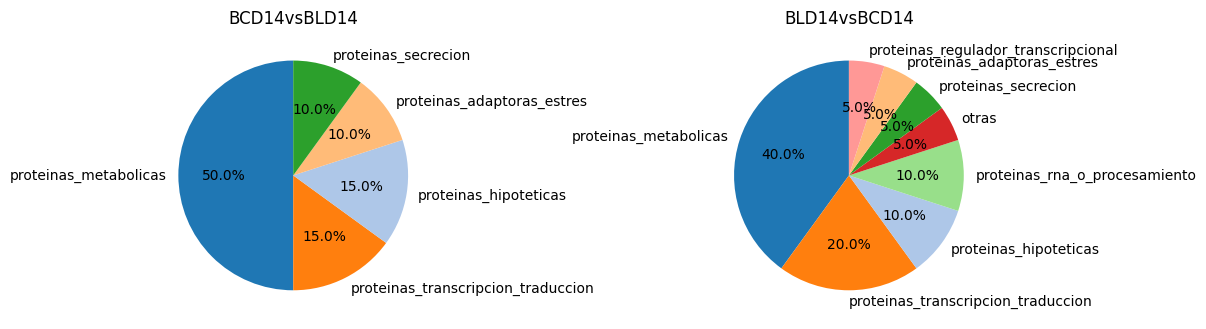

In [84]:


#Graficar los pays
#Set 1 BCD14 vs BLD14
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) #2 pays por grafico
axes[0].pie(bcd14vsbld14_clasificacion_protes_para_pay, labels=bcd14vsbld14_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bcd14vsbld14_clasificacion_protes_para_pay.index])
axes[0].set_title("BCD14vsBLD14")
axes[1].pie(bld14vsbcd14_clasificacion_protes_para_pay, labels=bld14vsbcd14_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bld14vsbcd14_clasificacion_protes_para_pay.index])
axes[1].set_title('BLD14vsBCD14')
#plt.title("Comparación de grupos de proteínas expresados al día 14 entre cepas BC y BL")
plt.tight_layout()
plt.show()


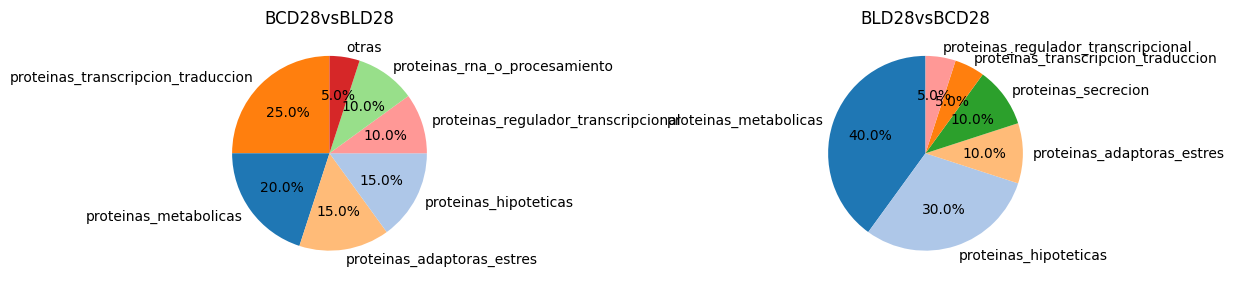

In [85]:
#Graficar los pays
#Set 2 BCD28 vs BLD28
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) #2 pays por grafico
axes[0].pie(bcd28vsbld28_clasificacion_protes_para_pay, labels=bcd28vsbld28_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bcd28vsbld28_clasificacion_protes_para_pay.index])
axes[0].set_title("BCD28vsBLD28")
axes[1].pie(bld28vsbcd28_clasificacion_protes_para_pay, labels=bld28vsbcd28_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bld28vsbcd28_clasificacion_protes_para_pay.index])
axes[1].set_title('BLD28vsBCD28')
#plt.title("Comparación de grupos de proteínas expresados al día 14 entre cepas BC y BL")
plt.tight_layout()
plt.show()

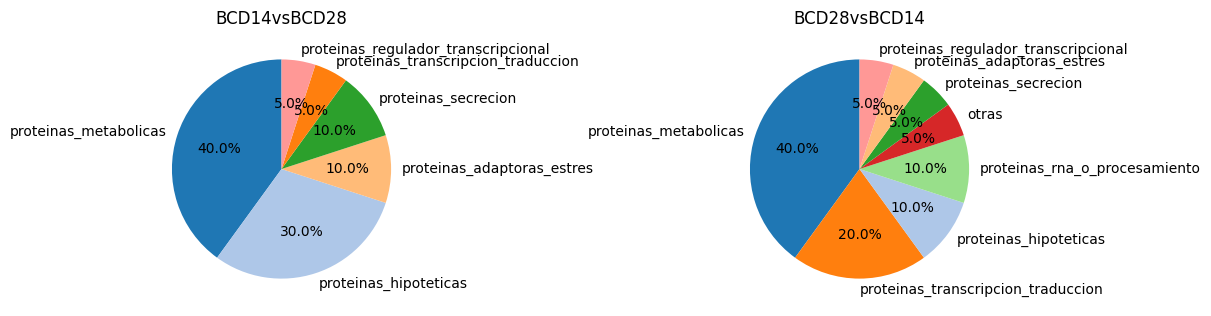

In [86]:
#Graficar los pays *No presentar*
#Set 3 BCd14 vs BCd28
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) #2 pays por grafico
axes[0].pie(bcd14vsbcd28_clasificacion_protes_para_pay, labels=bcd14vsbcd28_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bcd14vsbcd28_clasificacion_protes_para_pay.index])
axes[0].set_title("BCD14vsBCD28")
axes[1].pie(bcd28vsbcd14_clasificacion_protes_para_pay, labels=bcd28vsbcd14_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bcd28vsbcd14_clasificacion_protes_para_pay.index])
axes[1].set_title('BCD28vsBCD14')
#plt.title("Comparación de grupos de proteínas expresados al día 14 vs 28 en BC")
plt.tight_layout()
plt.show()

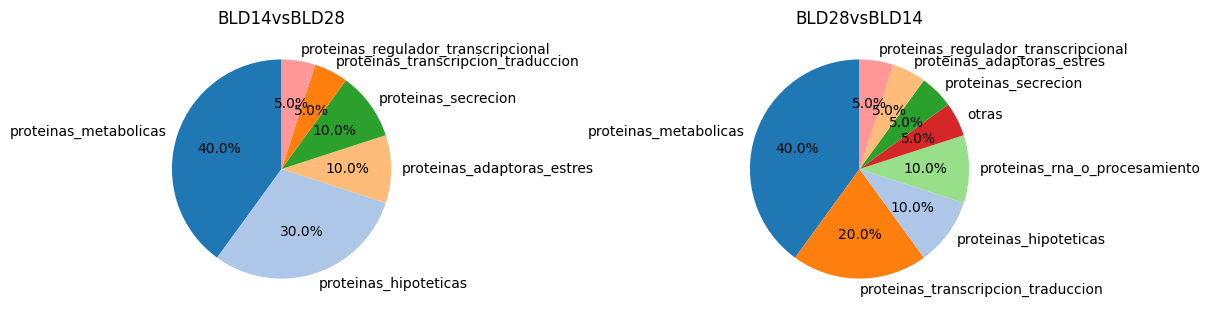

In [87]:
#Graficar los pays *No presentar, no relevante*
#Set 4 BLd14 vs BLd28
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) #2 pays por grafico
axes[0].pie(bld14vsbld28_clasificacion_protes_para_pay, labels=bld14vsbld28_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bld14vsbld28_clasificacion_protes_para_pay.index])
axes[0].set_title("BLD14vsBLD28")
axes[1].pie(bld28vsbld14_clasificacion_protes_para_pay, labels=bld28vsbld14_clasificacion_protes_para_pay.index, autopct='%1.1f%%', startangle=90, colors=[color_map[cat] for cat in bld28vsbld14_clasificacion_protes_para_pay.index])
axes[1].set_title('BLD28vsBLD14')
#plt.title("Comparación de grupos de proteínas expresados al día 14 vs 28 en BL")
plt.tight_layout()
plt.show()

['otras', 'proteinas_adaptoras_estres', 'proteinas_hipoteticas', 'proteinas_metabolicas', 'proteinas_regulador_transcripcional', 'proteinas_rna_o_procesamiento', 'proteinas_secrecion', 'proteinas_transcripcion_traduccion']


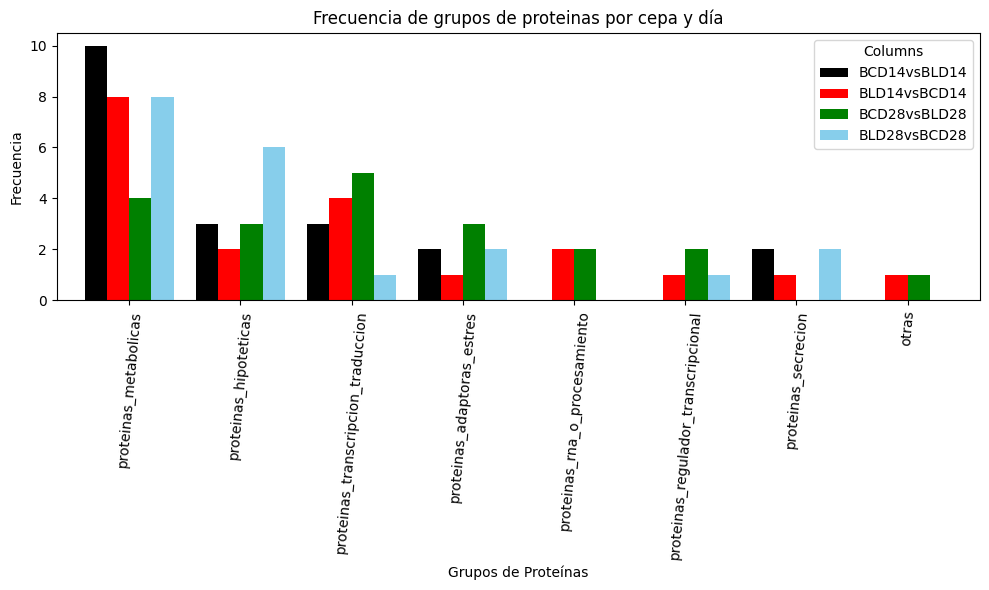

In [88]:
#Gráficos de barras
#revisar cuantos valores en común tengo entre las columnas de gene product como para hacer un mismo gráfico de barras comparativo.
basesotaBCD14vsBLD14
basesotaBLD14vsBCD14
basesotaBCD28vsBLD28
basesotaBLD28vsBCD28


basesotaBCD14vsBCD28
basesotaBCD28vsBCD14
basesotaBLD14vsBLD28
basesotaBLD28vsBLD14

#para barras comparativo de grupos de proteínas 
BCD14vsBLD14 = basesotaBCD14vsBLD14["clasificacion"].value_counts()
BLD14vsBCD14 = basesotaBLD14vsBCD14["clasificacion"].value_counts()
BCD28vsBLD28 = basesotaBCD28vsBLD28["clasificacion"].value_counts()
BLD28vsBCD28 = basesotaBLD28vsBCD28["clasificacion"].value_counts()

BLD14vsBLD28 = basesotaBLD14vsBLD28["clasificacion"].value_counts()
BLD28vsBLD14 = basesotaBLD28vsBLD14["clasificacion"].value_counts()



combine_indexes = BCD14vsBLD14.index.union(BLD14vsBCD14.index).union(BCD28vsBLD28.index).union(BLD28vsBCD28.index).union(BLD14vsBLD28.index).union(BLD28vsBLD14.index)
categories = sorted(combine_indexes)

print(categories)

#reindex
BCD14vsBLD14 = BCD14vsBLD14.reindex(categories, fill_value=0)
BLD14vsBCD14 = BLD14vsBCD14.reindex(categories, fill_value=0)
BCD28vsBLD28 = BCD28vsBLD28.reindex(categories, fill_value=0)
BLD28vsBCD28 = BLD28vsBCD28.reindex(categories, fill_value=0)

BLD14vsBLD28 = BLD14vsBLD28.reindex(categories, fill_value=0)
BLD28vsBLD14 = BLD28vsBLD14.reindex(categories, fill_value=0)

data_graph_bar_comparison = {"BCD14vsBLD14": BCD14vsBLD14,
"BLD14vsBCD14": BLD14vsBCD14,
"BCD28vsBLD28": BCD28vsBLD28, 
"BLD28vsBCD28": BLD28vsBCD28}
#"BLD14vsBLD28":BLD14vsBLD28,
#"BLD28vsBLD14":BLD28vsBLD14}
df = pd.DataFrame(data_graph_bar_comparison)


#ejex = basesota[basesota["clasificacion"]!= "proteinas_hipoteticas"]["clasificacion"].unique() #12 objetos
df["sort_key"] = df.max(axis=1)  # Create the sorting key using the max value across the columns
df = df.sort_values("sort_key", ascending=False)  # Sort by the sort_key in descending order

# Remove the helper column used for sorting
df = df.drop(columns=["sort_key"])
#graficar 
df.plot(kind='bar', figsize=(10, 6), width=0.8, color = ["black", "red", "green", "skyblue"]) #"brown", "orange",

plt.title("Frecuencia de grupos de proteinas por cepa y día")
plt.xlabel("Grupos de Proteínas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=85)
plt.legend(title="Columns")
plt.tight_layout()
plt.show()


,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion
74,75,gene-BJM02_06255,0.502819,-2.442162,2c8_didemethyl_8_hydroxy_5_deazariboflavin_syn...,BL,D28,bcd28vsbld28,proteinas_metabolicas
63,64,gene-BJM02_13365,0.748713,-2.683179,3_oxoacyl_acp_synthase,BL,D28,bcd28vsbld28,proteinas_metabolicas
69,70,gene-BJM02_04245,0.435619,-2.476311,amidophosphoribosyltransferase,BL,D28,bcd28vsbld28,proteinas_metabolicas
71,72,gene-BJM02_13010,0.271284,-2.464485,atp_dependent_clp_protease_proteolytic_subunit,BL,D28,bcd28vsbld28,proteinas_adaptoras_estres
76,77,gene-BJM02_20345,0.366810,-2.430551,bacterioferritin,BL,D28,bcd28vsbld28,proteinas_lipidos
61,62,gene-BJM02_02270,0.871927,-2.792418,chaperonin_grol,BL,D28,bcd28vsbld28,proteinas_adaptoras_estres
62,63,gene-BJM02_00690,0.439306,-2.685139,diacylglycerol_acyltransferase/mycolyltransfer...,BL,D28,bcd28vsbld28,proteinas_metabolicas
73,74,gene-BJM02_09845,0.213518,-2.462690,diacylglycerol_acyltransferase/mycolyltransfer...,BL,D28,bcd28vsbld28,proteinas_metabolicas
70,71,gene-BJM02_06380,0.220933,-2.465446,is256_family_transposase,BL,D28,bcd28vsbld28,proteinas_transposasa
78,79,gene-BJM02_19480,0.337684,-2.402747,penicillin_binding_protein,BL,D28,bcd28vsbld28,proteinas_intercalante_fagolisosomal


,Unnamed: 0,gen,base_mean,log2fc,geneproduct,cepa,dia,ref_comp,clasificacion
0,75,gene-BJM02_06255,0.502819,-2.442162,2c8_didemethyl_8_hydroxy_5_deazariboflavin_syn...,BL,D28,bcd28vsbld28,proteinas_metabolicas
1,64,gene-BJM02_13365,0.748713,-2.683179,3_oxoacyl_acp_synthase,BL,D28,bcd28vsbld28,proteinas_metabolicas
2,70,gene-BJM02_04245,0.435619,-2.476311,amidophosphoribosyltransferase,BL,D28,bcd28vsbld28,proteinas_metabolicas
3,72,gene-BJM02_13010,0.271284,-2.464485,atp_dependent_clp_protease_proteolytic_subunit,BL,D28,bcd28vsbld28,proteinas_adaptoras_estres
4,77,gene-BJM02_20345,0.366810,-2.430551,bacterioferritin,BL,D28,bcd28vsbld28,proteinas_lipidos
5,62,gene-BJM02_02270,0.871927,-2.792418,chaperonin_grol,BL,D28,bcd28vsbld28,proteinas_adaptoras_estres
6,71,gene-BJM02_06380,0.220933,-2.465446,is256_family_transposase,BL,D28,bcd28vsbld28,proteinas_transposasa
7,79,gene-BJM02_19480,0.337684,-2.402747,penicillin_binding_protein,BL,D28,bcd28vsbld28,proteinas_intercalante_fagolisosomal
8,68,gene-BJM02_13210,0.685660,-2.477433,pyruvate_dehydrogenase_(acetyl_transferring)_e...,BL,D28,bcd28vsbld28,proteinas_metabolicas
9,69,gene-BJM02_16110,0.237116,-2.476723,tetr_family_transcriptional_regulator,BL,D28,bcd28vsbld28,proteinas_regulador_transcripcional


C:\Users\david\AppData\Local\Temp\ipykernel_8556\2765422870.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


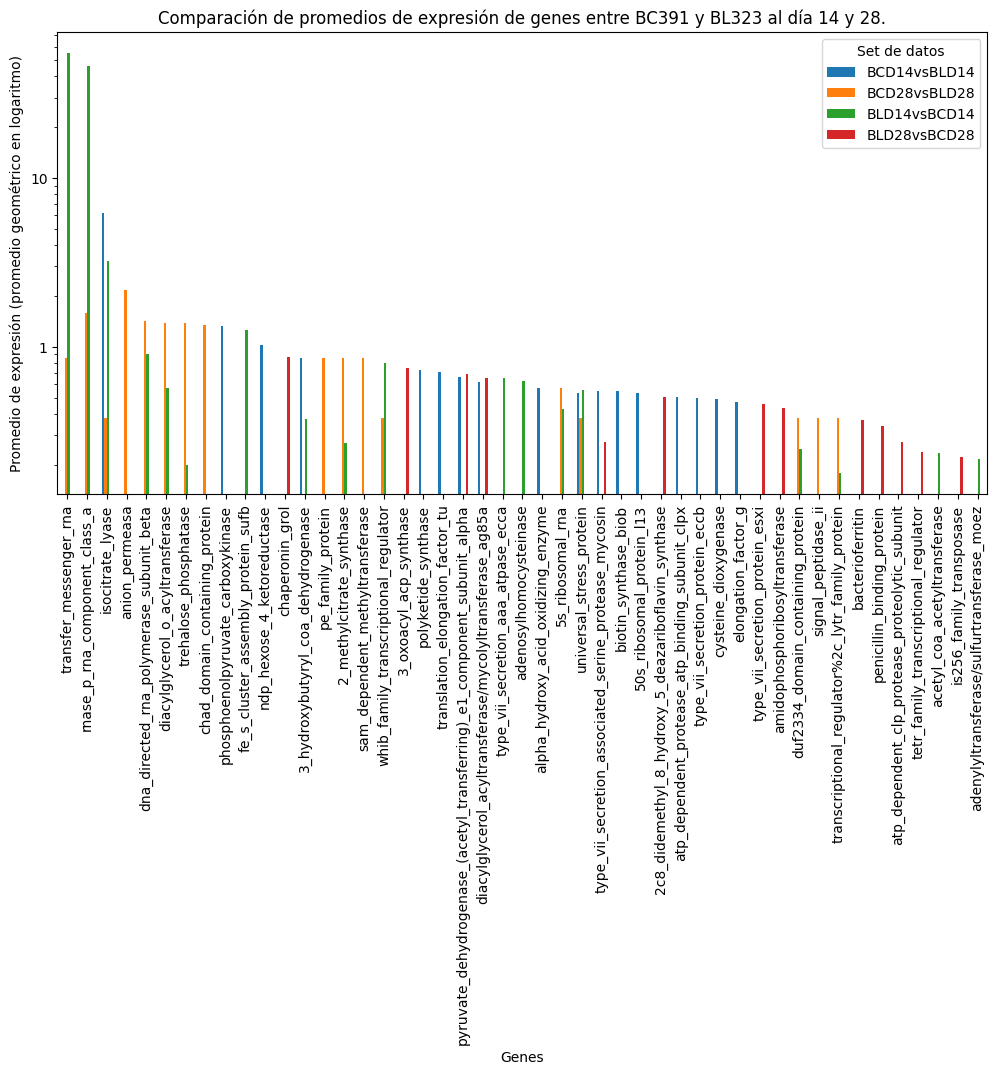

In [136]:
#Grafico de barras de cantidades
#remover hipoteticos
basesotaBCD14vsBLD14_sin_hipoteticos = basesotaBCD14vsBLD14[basesotaBCD14vsBLD14["clasificacion"]!="proteinas_hipoteticas"]
basesotaBLD14vsBCD14_sin_hipoteticos = basesotaBLD14vsBCD14[basesotaBLD14vsBCD14["clasificacion"]!="proteinas_hipoteticas"]
basesotaBCD28vsBLD28_sin_hipoteticos = basesotaBCD28vsBLD28[basesotaBCD28vsBLD28["clasificacion"]!="proteinas_hipoteticas"]
basesotaBLD28vsBCD28_sin_hipoteticos = basesotaBLD28vsBCD28[basesotaBLD28vsBCD28["clasificacion"]!="proteinas_hipoteticas"]
display(basesotaBLD28vsBCD28_sin_hipoteticos) #revisión de registro 62 y 73. ambos son Ag85 en el doc gff3. se sumará la expresión y se hará el promedio de log2fc. 
#arreglar ese detalle: 
#----
duplicates = basesotaBLD28vsBCD28_sin_hipoteticos["geneproduct"].duplicated(keep=False)

# Combine duplicates into one row
if duplicates.any():
    duplicate_rows = basesotaBLD28vsBCD28_sin_hipoteticos[duplicates]
    combined_row = {
        "Unnamed: 0": duplicate_rows["Unnamed: 0"].iloc[0],  # Keep the first index
        "gen": ", ".join(duplicate_rows["gen"]),  # Combine gen values as a string
        "base_mean": duplicate_rows["base_mean"].sum(),  # Sum base_mean
        "log2fc": duplicate_rows["log2fc"].abs().mean(),  # Mean of absolute log2fc
        "geneproduct": duplicate_rows["geneproduct"].iloc[0],  # Keep the first description
        "cepa": duplicate_rows["cepa"].iloc[0],  # Keep one value of cepa
        "dia": duplicate_rows["dia"].iloc[0],  # Keep one value of dia
        "ref_comp": duplicate_rows["ref_comp"].iloc[0],  # Keep one value of ref_comp
        "clasificacion": duplicate_rows["clasificacion"].iloc[0],  # Keep one value of clasificacion
    }

    # Remove duplicate rows and add the combined row
    basesotaBLD28vsBCD28_sin_hipoteticos = basesotaBLD28vsBCD28_sin_hipoteticos[~duplicates]
    basesotaBLD28vsBCD28_sin_hipoteticos = pd.concat(
        [basesotaBLD28vsBCD28_sin_hipoteticos, pd.DataFrame([combined_row])],
        ignore_index=True,
    )

# Display the final DataFrame
display(basesotaBLD28vsBCD28_sin_hipoteticos)


#----
basesotaBCD14vsBCD28_sin_hipoteticos = basesotaBCD14vsBCD28[basesotaBCD14vsBCD28["clasificacion"]!="proteinas_hipoteticas"]
basesotaBCD28vsBCD14_sin_hipoteticos = basesotaBCD28vsBCD14[basesotaBCD28vsBCD14["clasificacion"]!="proteinas_hipoteticas"]
basesotaBLD14vsBLD28_sin_hipoteticos = basesotaBLD14vsBLD28[basesotaBLD14vsBLD28["clasificacion"]!="proteinas_hipoteticas"]
basesotaBLD28vsBLD14_sin_hipoteticos = basesotaBLD28vsBLD14[basesotaBLD28vsBLD14["clasificacion"]!="proteinas_hipoteticas"]

#generar los valores separados de promedios

#unificar indices
cantidad_genes = basesota["geneproduct"].nunique() #49 totales, menos hipoteticos :) 

BCD14vsBLD14 = basesotaBCD14vsBLD14_sin_hipoteticos[["geneproduct", "base_mean"]]
BLD14vsBCD14 = basesotaBLD14vsBCD14_sin_hipoteticos[["geneproduct", "base_mean"]]
BCD28vsBLD28 = basesotaBCD28vsBLD28_sin_hipoteticos[["geneproduct", "base_mean"]]
BLD28vsBCD28 = basesotaBLD28vsBCD28_sin_hipoteticos[["geneproduct", "base_mean"]]

BCD14vsBCD28 = basesotaBCD14vsBCD28_sin_hipoteticos[["geneproduct", "base_mean"]]
BCD28vsBCD14 = basesotaBCD28vsBCD14_sin_hipoteticos[["geneproduct", "base_mean"]]
BLD14vsBLD28 = basesotaBLD14vsBLD28_sin_hipoteticos[["geneproduct", "base_mean"]]
BLD28vsBLD14 = basesotaBLD28vsBLD14_sin_hipoteticos[["geneproduct", "base_mean"]]

labels = ['BCD14vsBLD14', 'BLD14vsBCD14', 'BCD28vsBLD28', 'BLD28vsBCD28']

dfs = [BCD14vsBLD14, BLD14vsBCD14, BCD28vsBLD28, BLD28vsBCD28] #solamente BC vs BL por día

for i, label in enumerate(labels):
    dfs[i] = dfs[i].copy()  # Crear copia para evitar modificar el original
    dfs[i]['dataset'] = label 

merged_df_de_los_4 = pd.concat(dfs)  # Adds keys for identifying dfs
merged_df = merged_df_de_los_4.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
#acomodar los valores en descendiente
pivot_df["sort_key"] = pivot_df.max(axis=1)  # Create the sorting key using the max value across the columns
pivot_df = pivot_df.sort_values("sort_key", ascending=False)  # Sort by the sort_key in descending order

# Remove the helper column used for sorting
pivot_df = pivot_df.drop(columns=["sort_key"])
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes entre BC391 y BL323 al día 14 y 28.")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

#formato
#plt.figure(figsize=(10, 6))
#plt.bar(eje_x_simplista, promedios_eje_y_BLD14 - 0.2, width = 0.4, label = "Promedio expresión BLD14", color = "skyblue")
#plt.bar(eje_x_simplista, promedios_eje_y_BLD28 + 0.2, width= 0.4, label = "Promedio expresión BLD28", color = "orange")
#
#plt.xlabel("Genes")
#plt.ylabel("Promedio de expresión")
#plt.title("Comparación de expresión de genes sobreexpresados al día 14 y 28 de infección por la cepa BL")
##plt.xticks(range(0, 20))
#plt.legend()
#plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_8556\1357103275.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


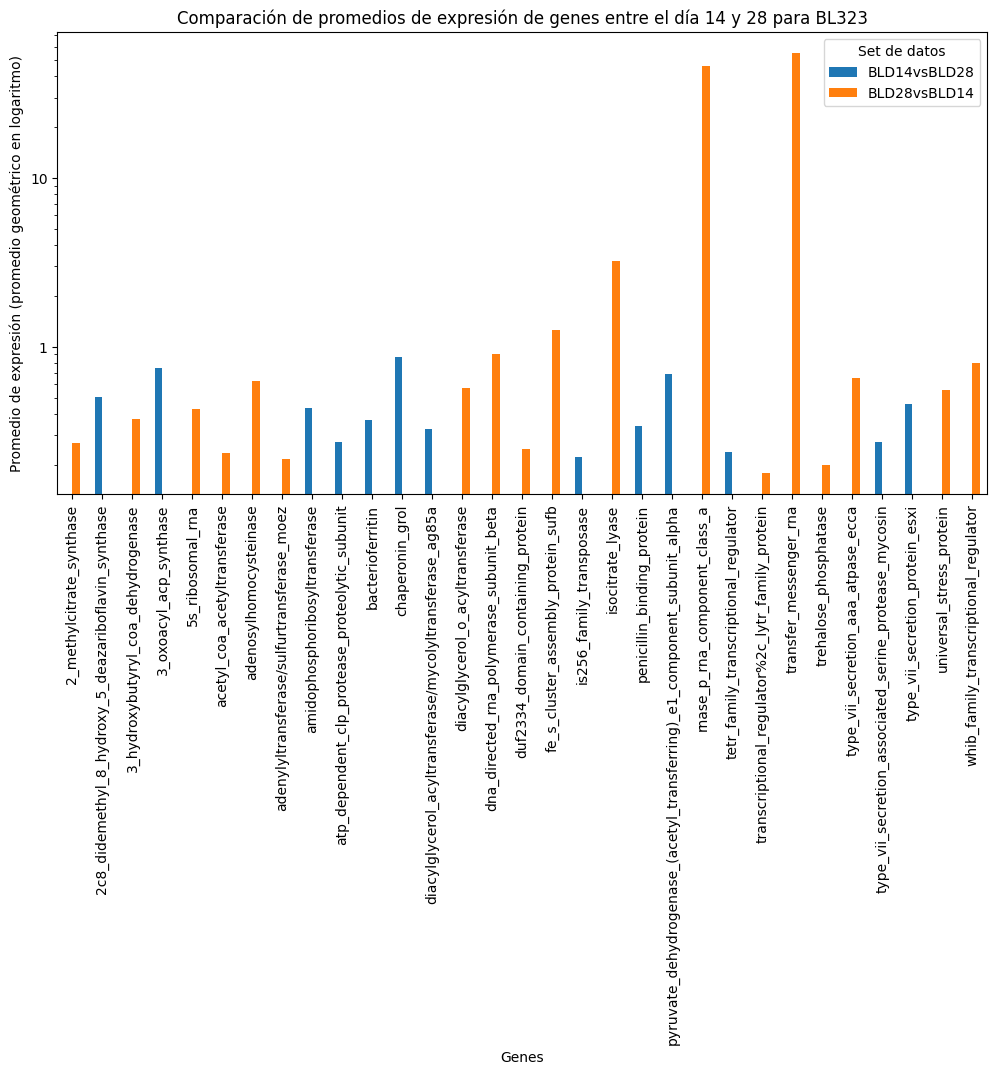

In [137]:
#Comparación de BLD14 vs BLD28 
labels = ["BLD14vsBLD28", "BLD28vsBLD14"]
dfs2 =[BLD14vsBLD28, BLD28vsBLD14]

for i, label in enumerate(labels):
    dfs2[i] = dfs2[i].copy()  # Crear copia para evitar modificar el original
    dfs2[i]['dataset'] = label 
    
merged_df = pd.concat(dfs2)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes entre el día 14 y 28 para BL323")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_8556\1329980793.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


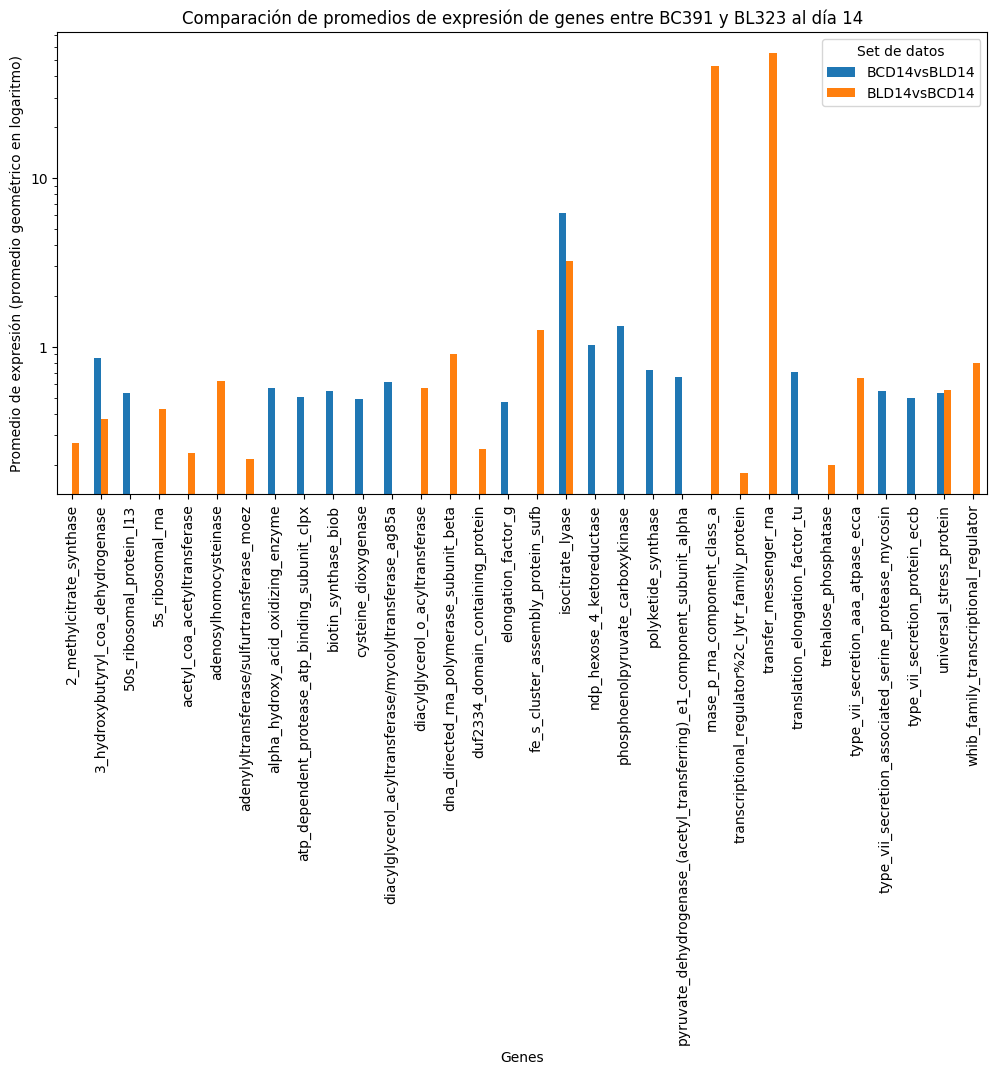

In [138]:
#Para BCvsBlD14 
#Comparación de BLD14 vs BLD28 
labels = ["BCD14vsBLD14", "BLD14vsBCD14"]
dfs3 =[BCD14vsBLD14, BLD14vsBCD14]

for i, label in enumerate(labels):
    dfs3[i] = dfs3[i].copy()  # Crear copia para evitar modificar el original
    dfs3[i]['dataset'] = label 
    
merged_df = pd.concat(dfs3)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes entre BC391 y BL323 al día 14")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()


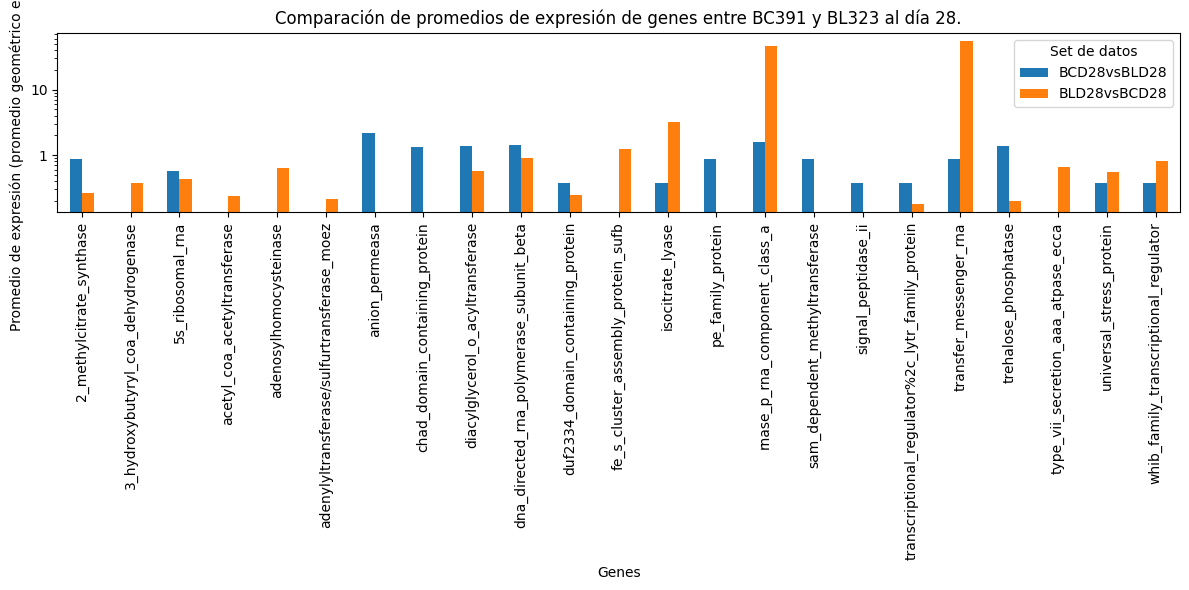

In [139]:
#Para BCvsBLD28
#Para BCvsBlD14 
#Comparación de BLD14 vs BLD28 
labels = ["BCD28vsBLD28", "BLD28vsBCD28"]
dfs5 =[BCD28vsBLD28, BLD28vsBLD14]
for i, label in enumerate(labels):
    dfs5[i] = dfs5[i].copy()  # Crear copia para evitar modificar el original
    dfs5[i]['dataset'] = label 
    
merged_df = pd.concat(dfs5)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes entre BC391 y BL323 al día 28.")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_8556\2605747837.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


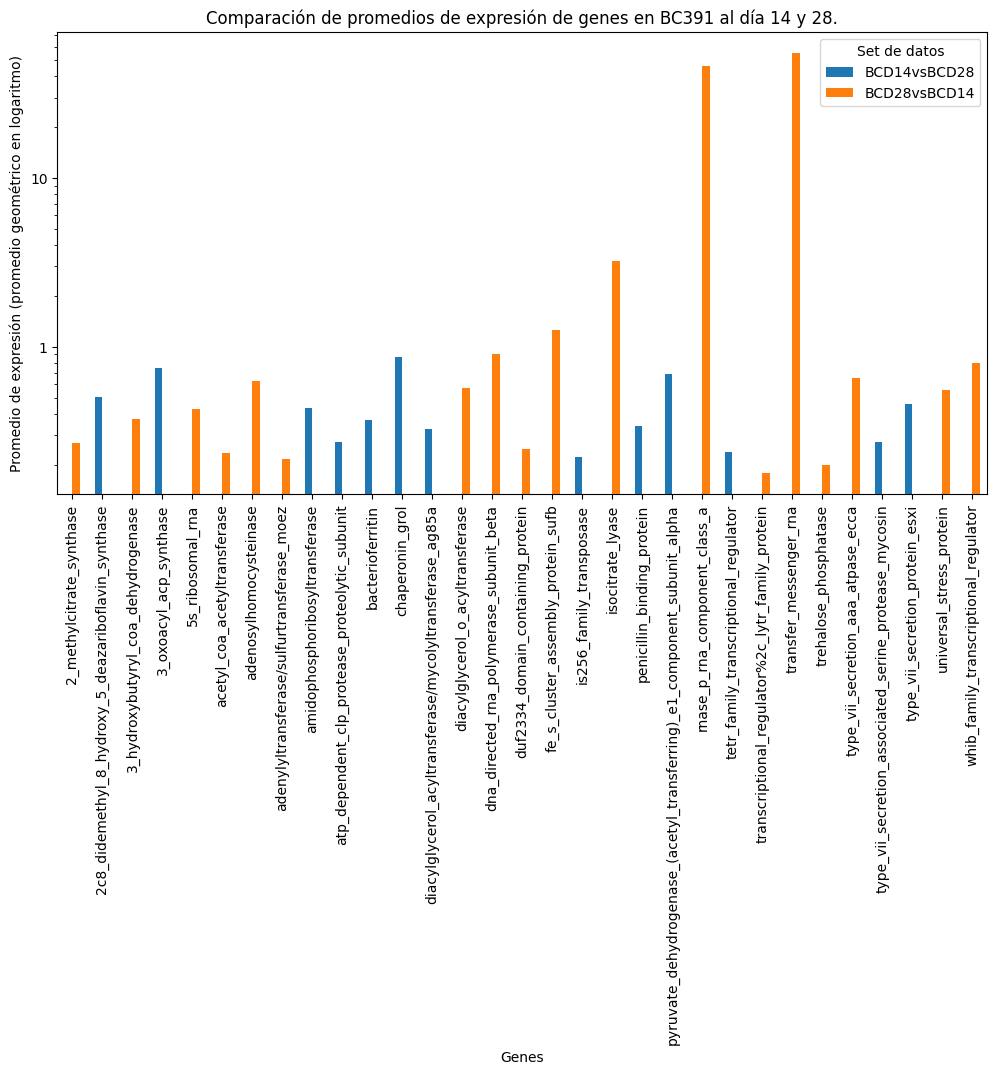

In [140]:
#Para BCD14vsBCD28
#Comparación de BLD14 vs BLD28 
labels = ["BCD14vsBCD28", "BCD28vsBCD14"]
dfs6 =[BCD14vsBCD28, BCD28vsBCD14]
for i, label in enumerate(labels):
    dfs6[i] = dfs6[i].copy()  # Crear copia para evitar modificar el original
    dfs6[i]['dataset'] = label 
    
merged_df = pd.concat(dfs6)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes en BC391 al día 14 y 28.")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_8556\868251878.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


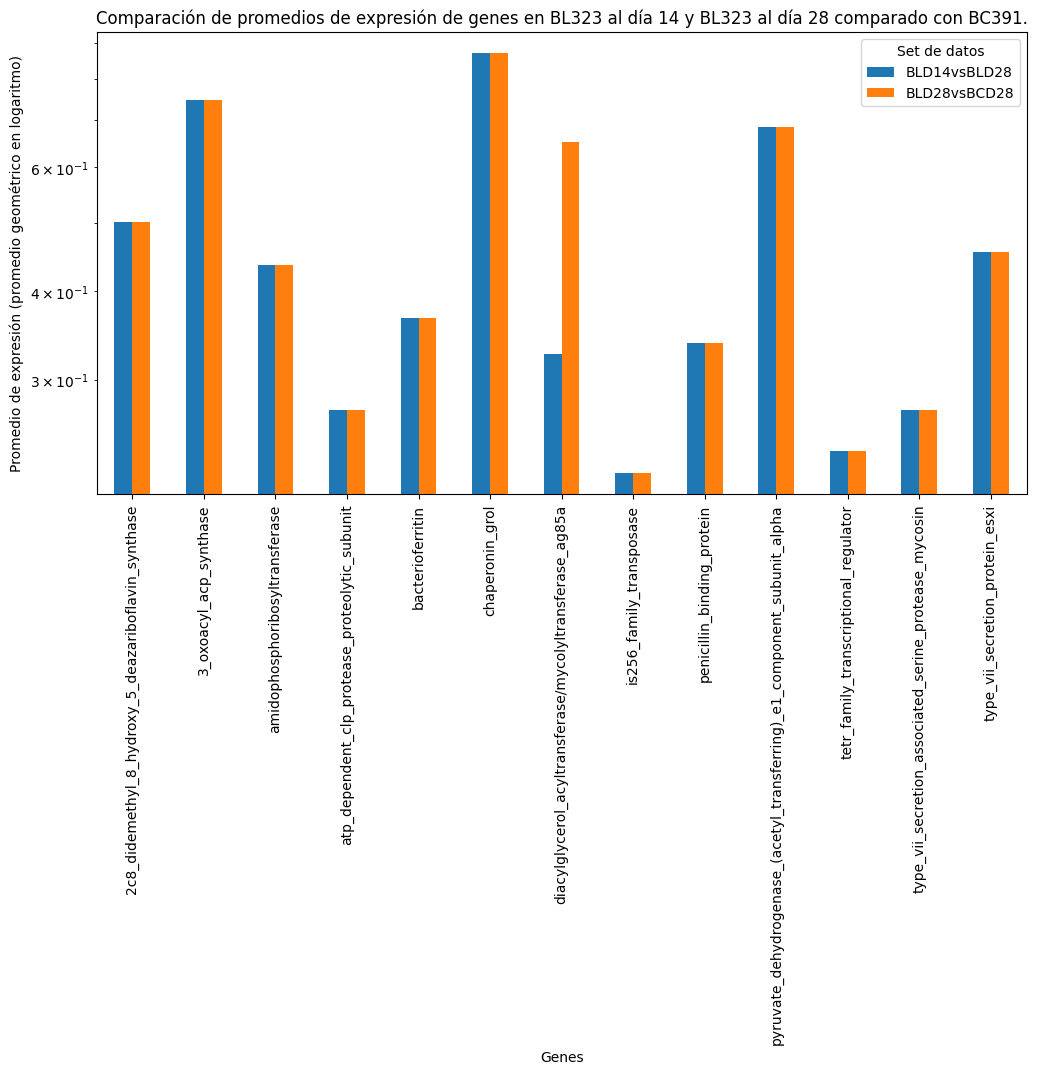

In [141]:
#tengo aparentes réplicas en BLD14vsBLD28 y BLD28vsBCD28 entonces compararé sus promedios. #hay un detalle de las comparaciones entre promedios geométricos que no entiendo.
#este no se reporta por ese detalle curioso del promedio geométrico que no creo esté mal hecho sino algo falta por aprender.  
#Comparación de BLD14vsBLD28 vs BLD28vsBCD28
labels = ["BLD14vsBLD28", "BLD28vsBCD28"]
dfs7 =[BLD14vsBLD28, BLD28vsBCD28]
for i, label in enumerate(labels):
    dfs7[i] = dfs7[i].copy()  # Crear copia para evitar modificar el original
    dfs7[i]['dataset'] = label 
    
merged_df = pd.concat(dfs7)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedios de expresión de genes en BL323 al día 14 y BL323 al día 28 comparado con BC391.")
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

#tengo una réplica de alguna forma en esas 2 filas. 

C:\Users\david\AppData\Local\Temp\ipykernel_8556\1975143212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCD14vsBLD14["log2fc"] = BCD14vsBLD14["log2fc"].abs()
C:\Users\david\AppData\Local\Temp\ipykernel_8556\1975143212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BLD14vsBCD14["log2fc"] = BLD14vsBCD14["log2fc"].abs()
C:\Users\david\AppData\Local\Temp\ipykernel_8556\1975143212.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

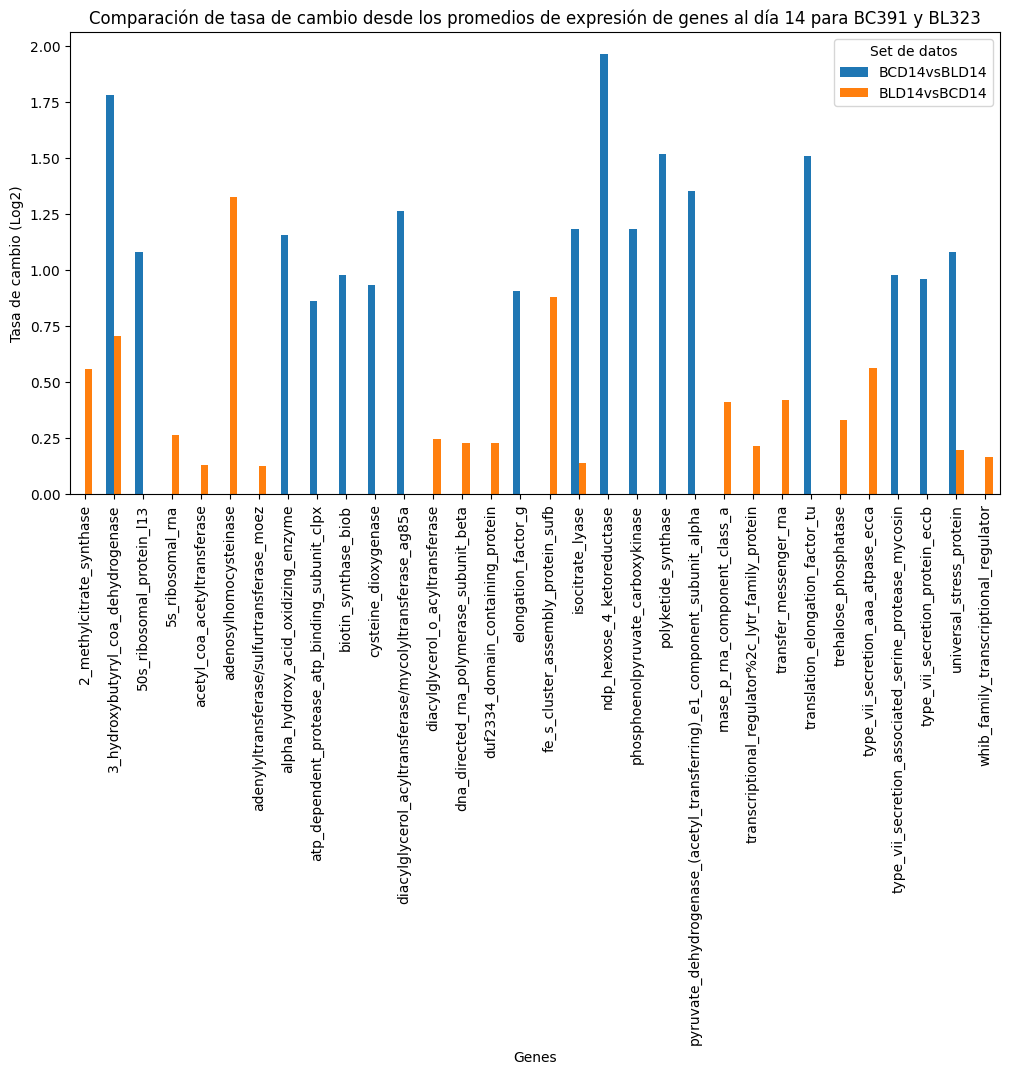

In [142]:
#Log 2 fc. Grado de cambio desde el promedio. 
#Grupos de comparación #
#BCvsBLD14, BCvsBLD28, BCD14vsBCD28, BLD14vsBLD28, algo más?
BCD14vsBLD14 = basesotaBCD14vsBLD14_sin_hipoteticos[["geneproduct", "log2fc"]]
BLD14vsBCD14 = basesotaBLD14vsBCD14_sin_hipoteticos[["geneproduct", "log2fc"]]
BCD28vsBLD28 = basesotaBCD28vsBLD28_sin_hipoteticos[["geneproduct", "log2fc"]]
BLD28vsBCD28 = basesotaBLD28vsBCD28_sin_hipoteticos[["geneproduct", "log2fc"]]

BCD14vsBLD14["log2fc"] = BCD14vsBLD14["log2fc"].abs()
BLD14vsBCD14["log2fc"] = BLD14vsBCD14["log2fc"].abs()
BCD28vsBLD28["log2fc"] = BCD28vsBLD28["log2fc"].abs()
BLD28vsBCD28["log2fc"] = BLD28vsBCD28["log2fc"].abs()



BCD14vsBCD28 = basesotaBCD14vsBCD28_sin_hipoteticos[["geneproduct", "log2fc"]]
BCD28vsBCD14 = basesotaBCD28vsBCD14_sin_hipoteticos[["geneproduct", "log2fc"]]
BLD14vsBLD28 = basesotaBLD14vsBLD28_sin_hipoteticos[["geneproduct", "log2fc"]]
BLD28vsBLD14 = basesotaBLD28vsBLD14_sin_hipoteticos[["geneproduct", "log2fc"]]

BCD14vsBCD28["log2fc"] = BCD14vsBCD28["log2fc"].abs()
BCD28vsBCD14["log2fc"] = BCD28vsBCD14["log2fc"].abs()
BLD14vsBLD28["log2fc"] = BLD14vsBLD28["log2fc"].abs()
BLD28vsBLD14["log2fc"] = BLD28vsBLD14["log2fc"].abs()

#Comparación de BCD14 vs BLD14 
labels = ["BCD14vsBLD14", "BLD14vsBCD14"]
dfs_log1 =[BCD14vsBLD14, BLD14vsBCD14]

for i, label in enumerate(labels):
    dfs_log1[i] = dfs_log1[i].copy()  # Crear copia para evitar modificar el original
    dfs_log1[i]['dataset'] = label 
    
merged_df1 = pd.concat(dfs_log1)  # Adds keys for identifying dfs
#print(merged_df1)
merged_df = merged_df1.groupby(['geneproduct', 'dataset']).mean().reset_index()
#print(merged_df) #lo mismo pero con el reset de indice. 
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='log2fc')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio desde los promedios de expresión de genes al día 14 para BC391 y BL323")
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (Log2)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()



C:\Users\david\AppData\Local\Temp\ipykernel_8556\2141579123.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


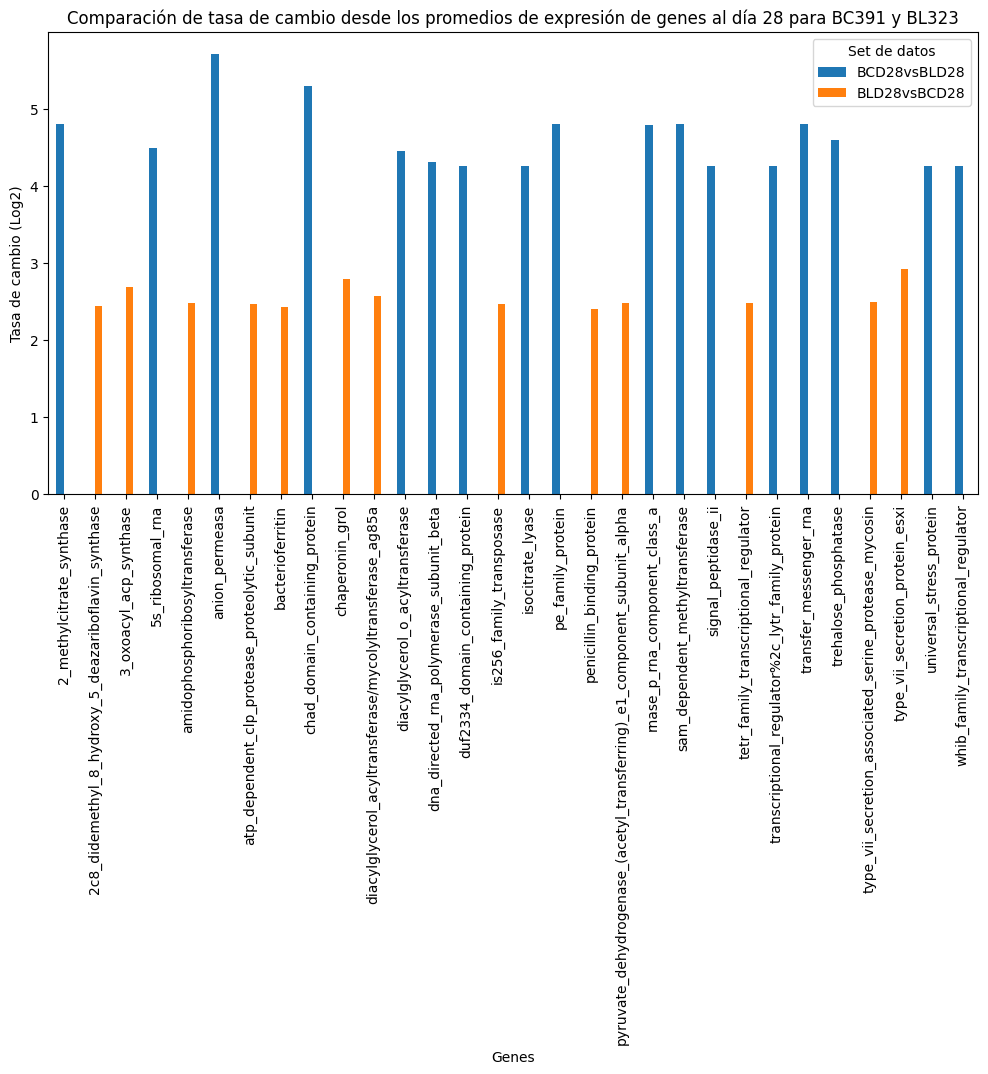

In [143]:
#BCvsBLD14, BCvsBLD28, BCD14vsBCD28, BLD14vsBLD28, algo más?

#Comparación de BCD28 vs BLD28
labels = ["BCD28vsBLD28", "BLD28vsBCD28"]
dfs_log2 =[BCD28vsBLD28, BLD28vsBCD28]

for i, label in enumerate(labels):
    dfs_log2[i] = dfs_log2[i].copy()  # Crear copia para evitar modificar el original
    dfs_log2[i]['dataset'] = label 
    
merged_df = pd.concat(dfs_log2)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='log2fc')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio desde los promedios de expresión de genes al día 28 para BC391 y BL323")
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (Log2)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos", loc = "upper right")
plt.tight_layout()

plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_8556\1665133363.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


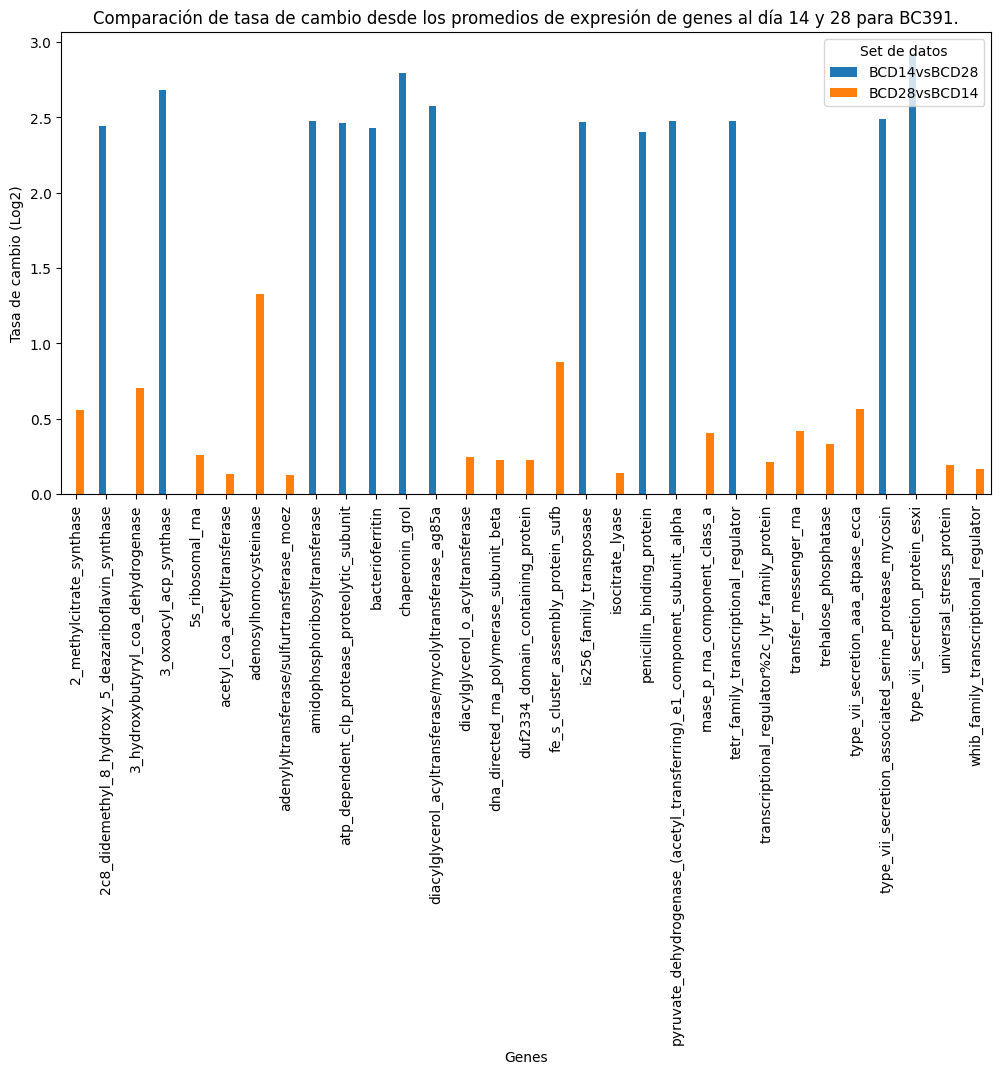

In [144]:
#BCvsBLD14, BCvsBLD28, BCD14vsBCD28, BLD14vsBLD28, algo más?

#Comparación de BCD14 vs BCD28
labels = ["BCD14vsBCD28", "BCD28vsBCD14"]
dfs_log3 =[BCD14vsBCD28, BCD28vsBCD14]

for i, label in enumerate(labels):
    dfs_log3[i] = dfs_log3[i].copy()  # Crear copia para evitar modificar el original
    dfs_log3[i]['dataset'] = label 
    
merged_df = pd.concat(dfs_log3)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='log2fc')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio desde los promedios de expresión de genes al día 14 y 28 para BC391.")
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (Log2)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos", loc = "upper right")
plt.tight_layout()

plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_8556\1227428783.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


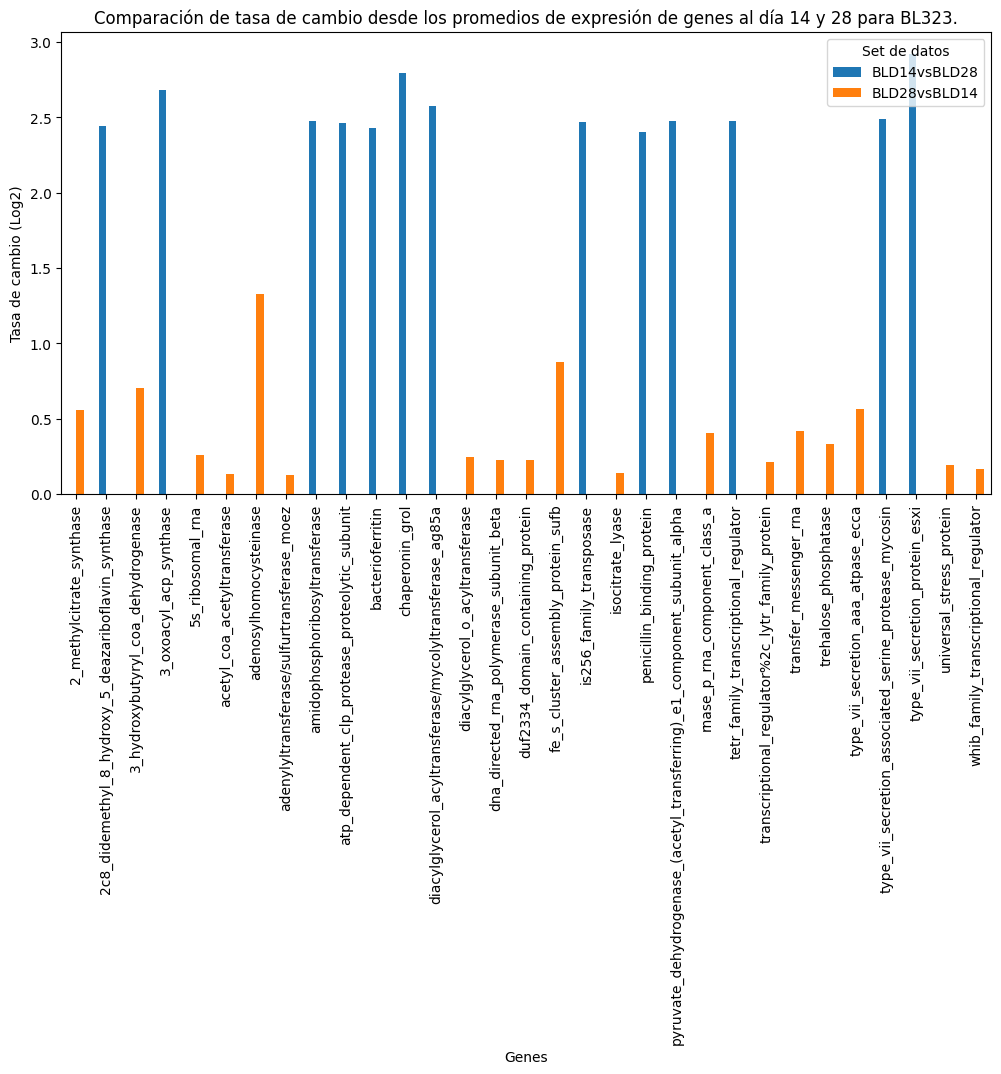

In [145]:
#BCvsBLD14, BCvsBLD28, BCD14vsBCD28, BLD14vsBLD28, algo más?

#Comparación de BLD14 vs BLD28
labels = ["BLD14vsBLD28", "BLD28vsBLD14"]
dfs_log4 =[BLD14vsBLD28, BLD28vsBLD14]

for i, label in enumerate(labels):
    dfs_log4[i] = dfs_log4[i].copy()  # Crear copia para evitar modificar el original
    dfs_log4[i]['dataset'] = label 
    
merged_df = pd.concat(dfs_log4)  # Adds keys for identifying dfs
merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
# Pivot the data to wide format
pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='log2fc')
# Fill missing values with 0
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', figsize=(12, 6))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio desde los promedios de expresión de genes al día 14 y 28 para BL323.")
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (Log2)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos", loc = "upper right")
plt.tight_layout()

plt.show()

## Seguimientos: 

1. Hacer el gráfico de expresión de promedios geométricos comparativos por grupo de proteínas. 
    
    *1er grupo. Proteínas metabólicas
    *2do grupo. Traducción y transcripción
    *3er grupo. Resistencia a estrés. 

2. En R. Modificar los ejes de los volcanes para que sean los mismos.

3. 

In [146]:
#Gráfico a tres gráficos. Met, trans-trad, estrés

#Revisión de los datos
#Para cuando se busque recrear con base_mean y log2fc
BCD14vsBLD14 = basesotaBCD14vsBLD14_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BLD14vsBCD14 = basesotaBLD14vsBCD14_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BCD28vsBLD28 = basesotaBCD28vsBLD28_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BLD28vsBCD28 = basesotaBLD28vsBCD28_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]


BCD14vsBCD28 = basesotaBCD14vsBCD28_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BCD28vsBCD14 = basesotaBCD28vsBCD14_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BLD14vsBLD28 = basesotaBLD14vsBLD28_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]
BLD28vsBLD14 = basesotaBLD28vsBLD14_sin_hipoteticos[["geneproduct", "base_mean", "log2fc"]]

BCD14vsBCD28["log2fc"] = BCD14vsBCD28["log2fc"].abs()
BCD28vsBCD14["log2fc"] = BCD28vsBCD14["log2fc"].abs()
BLD14vsBLD28["log2fc"] = BLD14vsBLD28["log2fc"].abs()
BLD28vsBLD14["log2fc"] = BLD28vsBLD14["log2fc"].abs()

display(BLD28vsBCD28)
labels = ['BCD14vsBLD14', 'BLD14vsBCD14', 'BCD28vsBLD28', 'BLD28vsBCD28']

dfs = [BCD14vsBLD14, BLD14vsBCD14, BCD28vsBLD28, BLD28vsBCD28] #solamente BC vs BL por día
#
for i, label in enumerate(labels):
    dfs[i] = dfs[i].copy()  # Crear copia para evitar modificar el original
    dfs[i]['dataset'] = label 

merged_df_de_los_4 = pd.concat(dfs)  # Adds keys for identifying dfs
merged_df_de_los_4["log2fc"] = merged_df_de_los_4["log2fc"].abs()
merged_df_de_los_4.info()
display(merged_df_de_los_4)
#merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
merged_df.info()
display(merged_df.head())
#merged_df_de_los_4.info() #datos erróneos lol ocupo los de los 4 juntos. Solo tiene BLd14 y BLd28. 
#merged_df_de_los_4.columns #'geneproduct', 'dataset', 'log2fc' #quiero que tenga log2fc y base_mean
#display(merged_df_de_los_4)

#hacer máscaras de filtrado para metabólico, trans-trad y estrés. 
 #Revisión de grupos de proteínas para separar. 
print(grupos_prote) #str de lista de listas. 
print(grupos_prote_dict) #diccionario de grupo:listas
print(grupos_prote_dict.keys()) #'proteinas_metabolicas', 'proteinas_secrecion', 'proteinas_transcripcion_traduccion', 'proteinas_adaptoras_estres', 'proteinas_alteracion_epigenomica', 'proteinas_intercalante_fagolisosomal', 'proteinas_sideroforo', 'proteinas_regulador_transcripcional', 'proteinas_rna_o_procesamiento', 'proteinas_lipidos', 'proteinas_transposasa',  #'proteinas_hipoteticas', 'otras' no serán contempladas

#1er grupo (met) serían: "proteinas_metabolicas", "proteinas_sideroforo", "proteinas_lipidos"
#Se considera que también las proteínas metabólicas de lípidos: "Polyketide synthase", "Diacylglycerol acyltransferase/mycolyltransferase Ag85A",
#"Diacylglycerol O-acyltransferase", "3-oxoacyl-ACP synthase", #Metabolismo lípidos, así como otras como isocitrato liasa. Pueden contribuir a virulencia.
#2do grupo (trans-trad): "proteinas_transcripcion_traduccion", "proteinas_alteracion_epigenomica", "proteinas_regulador_transcripcional", "proteinas_rna_o_procesamiento", "proteinas_transposasa"
#3er grupo (estrés): "proteinas_secrecion", "proteinas_adaptoras_estres", "proteinas_intercalante_fagolisosomal"
grupo_met = ["proteinas_metabolicas", "proteinas_sideroforo", "proteinas_lipidos"]
grupo_trans_trad = ["proteinas_transcripcion_traduccion", "proteinas_alteracion_epigenomica", "proteinas_regulador_transcripcional", "proteinas_rna_o_procesamiento", "proteinas_transposasa"]
grupo_estres = ["proteinas_secrecion", "proteinas_adaptoras_estres", "proteinas_intercalante_fagolisosomal"]

genes_metabolicos = []
genes_trans_trad = []
genes_estres = []
    
for key, value in grupos_prote_dict.items(): 
    if key in grupo_met:
        genes_metabolicos.extend(value)
    if key in grupo_trans_trad:
        genes_trans_trad.extend(value)
    if key in grupo_estres:
        genes_estres.extend(value)

print(genes_metabolicos)
print(genes_trans_trad)
print(genes_estres) #:D 

#generar máscaras
df_geneproduct = merged_df_de_los_4["geneproduct"]
mascara_met = df_geneproduct.isin(genes_metabolicos)
mascara_trans_trad = df_geneproduct.isin(genes_trans_trad)
mascara_estres = df_geneproduct.isin(genes_estres)

merged_df_met = merged_df_de_los_4[mascara_met].reset_index()
merged_df_trans_trad = merged_df_de_los_4[mascara_trans_trad].reset_index()
merged_df_estres = merged_df_de_los_4[mascara_estres].reset_index()

print("Solo datos metabólicos:")
display(merged_df_met)
print("Solo datos relacionados a transcripción y traducción:")
display(merged_df_trans_trad)
print("Solo datos relacionados a adaptación a estrés:")
display(merged_df_estres)

#Ok tengo ya mis marcos de datos separados. Falta hacer los gráficos de barras comparativos.



C:\Users\david\AppData\Local\Temp\ipykernel_8556\2530811721.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCD14vsBCD28["log2fc"] = BCD14vsBCD28["log2fc"].abs()
C:\Users\david\AppData\Local\Temp\ipykernel_8556\2530811721.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCD28vsBCD14["log2fc"] = BCD28vsBCD14["log2fc"].abs()
C:\Users\david\AppData\Local\Temp\ipykernel_8556\2530811721.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,geneproduct,base_mean,log2fc
0,2c8_didemethyl_8_hydroxy_5_deazariboflavin_syn...,0.502819,-2.442162
1,3_oxoacyl_acp_synthase,0.748713,-2.683179
2,amidophosphoribosyltransferase,0.435619,-2.476311
3,atp_dependent_clp_protease_proteolytic_subunit,0.271284,-2.464485
4,bacterioferritin,0.366810,-2.430551
5,chaperonin_grol,0.871927,-2.792418
6,is256_family_transposase,0.220933,-2.465446
7,penicillin_binding_protein,0.337684,-2.402747
8,pyruvate_dehydrogenase_(acetyl_transferring)_e...,0.685660,-2.477433
9,tetr_family_transcriptional_regulator,0.237116,-2.476723


<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 2 to 12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geneproduct  65 non-null     object 
 1   base_mean    65 non-null     float64
 2   log2fc       65 non-null     float64
 3   dataset      65 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.5+ KB


,geneproduct,base_mean,log2fc,dataset
2,3_hydroxybutyryl_coa_dehydrogenase,0.862903,1.780877,BCD14vsBLD14
11,50s_ribosomal_protein_l13,0.528420,1.079553,BCD14vsBLD14
9,alpha_hydroxy_acid_oxidizing_enzyme,0.571051,1.156598,BCD14vsBLD14
18,atp_dependent_protease_atp_binding_subunit_clpx,0.501412,0.861954,BCD14vsBLD14
13,biotin_synthase_biob,0.550370,0.975301,BCD14vsBLD14
...,...,...,...,...
8,pyruvate_dehydrogenase_(acetyl_transferring)_e...,0.685660,2.477433,BLD28vsBCD28
9,tetr_family_transcriptional_regulator,0.237116,2.476723,BLD28vsBCD28
10,type_vii_secretion_associated_serine_protease_...,0.271480,2.488832,BLD28vsBCD28
11,type_vii_secretion_protein_esxi,0.455298,2.919127,BLD28vsBCD28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geneproduct  31 non-null     object 
 1   dataset      31 non-null     object 
 2   log2fc       31 non-null     float64
dtypes: float64(1), object(2)
memory usage: 876.0+ bytes


,geneproduct,dataset,log2fc
0,2_methylcitrate_synthase,BLD28vsBLD14,0.559705
1,2c8_didemethyl_8_hydroxy_5_deazariboflavin_syn...,BLD14vsBLD28,2.442162
2,3_hydroxybutyryl_coa_dehydrogenase,BLD28vsBLD14,0.704865
3,3_oxoacyl_acp_synthase,BLD14vsBLD28,2.683179
4,5s_ribosomal_rna,BLD28vsBLD14,0.262226


[['ndp_hexose_4_ketoreductase', 'phosphoenolpyruvate_carboxykinase', 'trehalose_phosphatase', 'polyketide_synthase', 'diacylglycerol_acyltransferase/mycolyltransferase_ag85a', 'diacylglycerol_o_acyltransferase', '3_oxoacyl_acp_synthase', 'pyruvate_dehydrogenase_(acetyl_transferring)_e1_component_subunit_alpha', 'isocitrate_lyase', 'alpha_hydroxy_acid_oxidizing_enzyme', '2_methylcitrate_synthase', 'biotin_synthase_biob', 'cysteine_dioxygenase', '3_hydroxybutyryl_coa_dehydrogenase', 'acetyl_coa_acetyltransferase', 'amidophosphoribosyltransferase', 'adenosylhomocysteinase', '2c8_didemethyl_8_hydroxy_5_deazariboflavin_synthase'], ['type_vii_secretion_associated_serine_protease_mycosin', 'type_vii_secretion_protein_eccb', 'type_vii_secretion_aaa_atpase_ecca', 'type_vii_secretion_protein_esxi'], ['signal_peptidase_ii', 'translation_elongation_factor_tu', 'elongation_factor_g', '50s_ribosomal_protein_l3', '5s_ribosomal_rna', 'dna_directed_rna_polymerase_subunit_beta', 'transcriptional_regulat

,index,geneproduct,base_mean,log2fc,dataset
0,2,3_hydroxybutyryl_coa_dehydrogenase,0.862903,1.780877,BCD14vsBLD14
1,9,alpha_hydroxy_acid_oxidizing_enzyme,0.571051,1.156598,BCD14vsBLD14
2,13,biotin_synthase_biob,0.550370,0.975301,BCD14vsBLD14
3,16,cysteine_dioxygenase,0.491492,0.934039,BCD14vsBLD14
4,6,diacylglycerol_acyltransferase/mycolyltransfer...,0.617899,1.261184,BCD14vsBLD14
5,7,isocitrate_lyase,6.228448,1.181623,BCD14vsBLD14
6,0,ndp_hexose_4_ketoreductase,1.027724,1.961887,BCD14vsBLD14
7,8,phosphoenolpyruvate_carboxykinase,1.329283,1.180494,BCD14vsBLD14
8,3,polyketide_synthase,0.732278,1.514593,BCD14vsBLD14
9,5,pyruvate_dehydrogenase_(acetyl_transferring)_e...,0.664748,1.353410,BCD14vsBLD14


Solo datos relacionados a transcripción y traducción:


,index,geneproduct,base_mean,log2fc,dataset
0,11,50s_ribosomal_protein_l13,0.528420,1.079553,BCD14vsBLD14
1,17,elongation_factor_g,0.471651,0.905258,BCD14vsBLD14
2,4,translation_elongation_factor_tu,0.710328,1.505496,BCD14vsBLD14
3,29,5s_ribosomal_rna,0.428049,0.262226,BLD14vsBCD14
4,39,adenylyltransferase/sulfurtransferase_moez,0.216687,0.124991,BLD14vsBCD14
5,31,dna_directed_rna_polymerase_subunit_beta,0.901590,0.228071,BLD14vsBCD14
6,26,rnase_p_rna_component_class_a,45.914277,0.408481,BLD14vsBCD14
7,33,transcriptional_regulator%2c_lytr_family_protein,0.178281,0.212612,BLD14vsBCD14
8,25,transfer_messenger_rna,55.028151,0.420638,BLD14vsBCD14
9,36,whib_family_transcriptional_regulator,0.799127,0.163857,BLD14vsBCD14


Solo datos relacionados a adaptación a estrés:


,index,geneproduct,base_mean,log2fc,dataset
0,18,atp_dependent_protease_atp_binding_subunit_clpx,0.501412,0.861954,BCD14vsBLD14
1,14,type_vii_secretion_associated_serine_protease_...,0.550370,0.975301,BCD14vsBLD14
2,15,type_vii_secretion_protein_eccb,0.493601,0.959498,BCD14vsBLD14
3,10,universal_stress_protein,0.528420,1.079553,BCD14vsBLD14
4,23,type_vii_secretion_aaa_atpase_ecca,0.650641,0.563214,BLD14vsBCD14
5,34,universal_stress_protein,0.557129,0.196061,BLD14vsBCD14
6,40,anion_permeasa,2.167183,5.706976,BCD28vsBLD28
7,41,chad_domain_containing_protein,1.343270,5.295131,BCD28vsBLD28
8,54,universal_stress_protein,0.379868,4.251166,BCD28vsBLD28
9,3,atp_dependent_clp_protease_proteolytic_subunit,0.271284,2.464485,BLD28vsBCD28


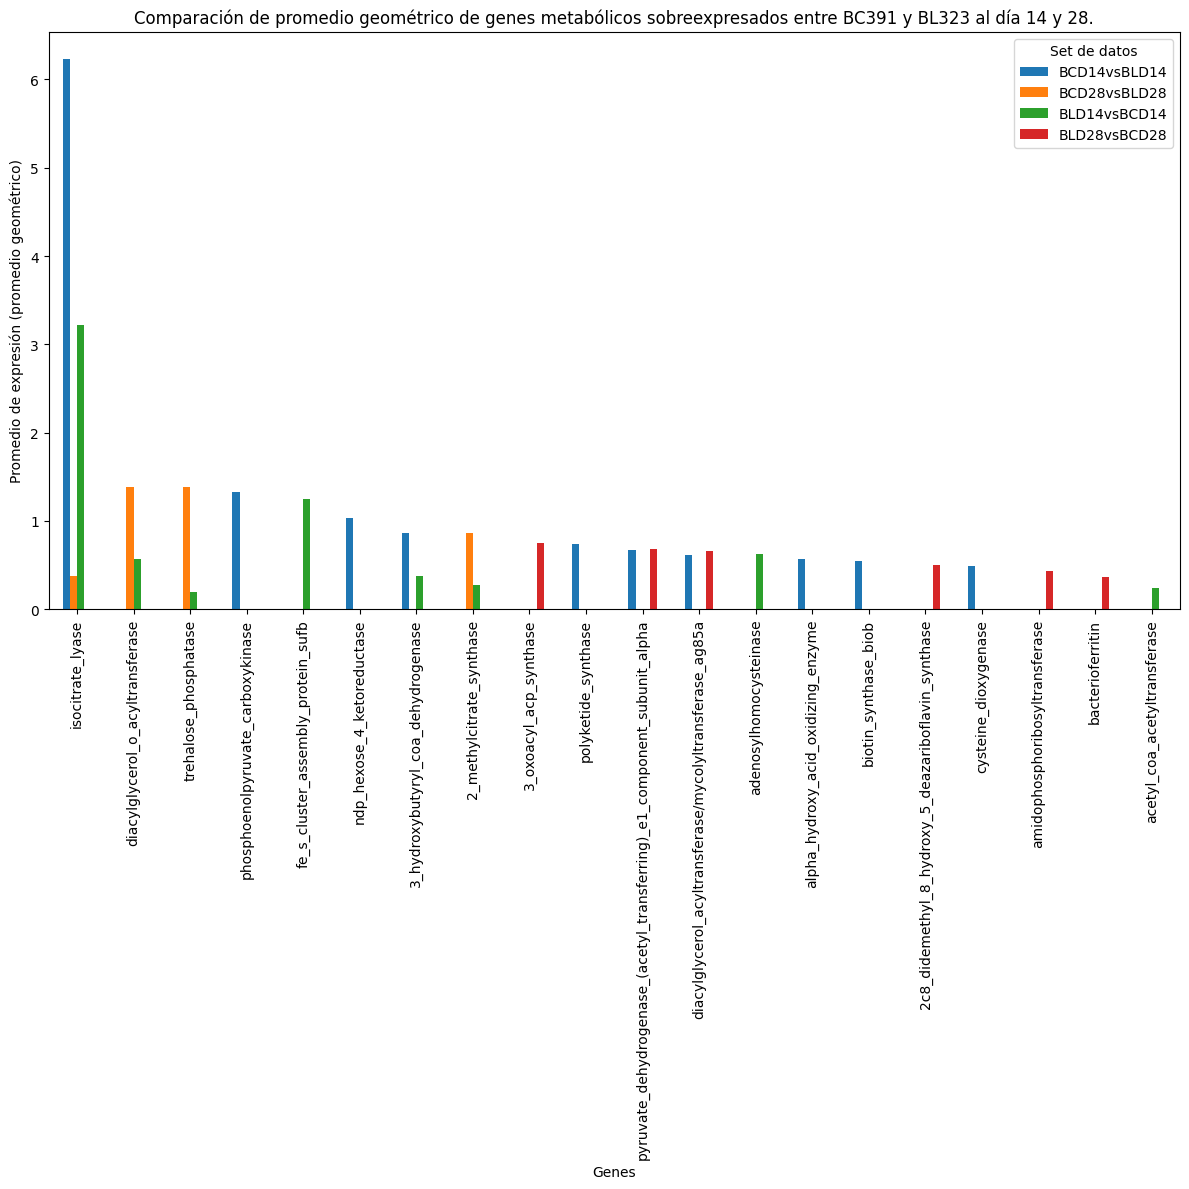

In [147]:
#1er gráfico: metabólico 
#datos
merged_df_met #cols: "geneproduct", "dataset", "log2fc" #sería bueno hacerlo también con promedios geométricos?

#----#
#Para cuando se busque recrear con base_mean
#BCD14vsBLD14 = basesotaBCD14vsBLD14_sin_hipoteticos[["geneproduct", "base_mean"]]
#BLD14vsBCD14 = basesotaBLD14vsBCD14_sin_hipoteticos[["geneproduct", "base_mean"]]
#BCD28vsBLD28 = basesotaBCD28vsBLD28_sin_hipoteticos[["geneproduct", "base_mean"]]
#BLD28vsBCD28 = basesotaBLD28vsBCD28_sin_hipoteticos[["geneproduct", "base_mean"]]
#
#BCD14vsBCD28 = basesotaBCD14vsBCD28_sin_hipoteticos[["geneproduct", "base_mean"]]
#BCD28vsBCD14 = basesotaBCD28vsBCD14_sin_hipoteticos[["geneproduct", "base_mean"]]
#BLD14vsBLD28 = basesotaBLD14vsBLD28_sin_hipoteticos[["geneproduct", "base_mean"]]
#BLD28vsBLD14 = basesotaBLD28vsBLD14_sin_hipoteticos[["geneproduct", "base_mean"]]
#
#labels = ['BCD14vsBLD14', 'BLD14vsBCD14', 'BCD28vsBLD28', 'BLD28vsBCD28']
#
#dfs = [BCD14vsBLD14, BLD14vsBCD14, BCD28vsBLD28, BLD28vsBCD28] #solamente BC vs BL por día
#
#for i, label in enumerate(labels):
#    dfs[i] = dfs[i].copy()  # Crear copia para evitar modificar el original
#    dfs[i]['dataset'] = label 
#
#merged_df = pd.concat(dfs)  # Adds keys for identifying dfs
#merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
## Pivot the data to wide format
#pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
## Fill missing values with 0
#pivot_df = pivot_df.fillna(0)

#----#

pivot_met = merged_df_met.pivot(index="geneproduct", columns = "dataset", values= "base_mean")
pivot_met_log2fc = merged_df_met.pivot(index="geneproduct", columns = "dataset", values= "log2fc")
pivot_met = pivot_met.fillna(0)
pivot_met_log2fc = pivot_met_log2fc.fillna(0)
#display(pivot_met)
#display(pivot_met_log2fc)
#Ordenar los datos 
# Sort rows by the maximum value across datasets
pivot_met["sort_key"] = pivot_met.max(axis=1)  # Sort by the highest value
pivot_met = pivot_met.sort_values("sort_key", ascending=False)  # Sort descending
pivot_met = pivot_met.drop(columns=["sort_key"])  # Drop the helper column

#gráfico
pivot_met.plot(kind='bar', figsize=(12, 12))#, logy=True) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedio geométrico de genes metabólicos sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

#código ejemplo de datos previos y gráfico previo: 
#merged_df = pd.concat(dfs)  # Adds keys for identifying dfs
#merged_df = merged_df.groupby(['geneproduct', 'dataset']).mean().reset_index()
## Pivot the data to wide format
#pivot_df = merged_df.pivot(index='geneproduct', columns='dataset', values='base_mean')
## Fill missing values with 0
#pivot_df = pivot_df.fillna(0)
#pivot_df.plot(kind='bar', figsize=(12, 6), logy=True)
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

#plt.title("Comparación de promedios de expresión de genes entre BC391 y BL323 al día 14 y 28.")
#plt.xlabel("Genes")
#plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
#plt.xticks(rotation=90)
#plt.legend(title="Set de datos")
#plt.tight_layout()
#
#plt.show()


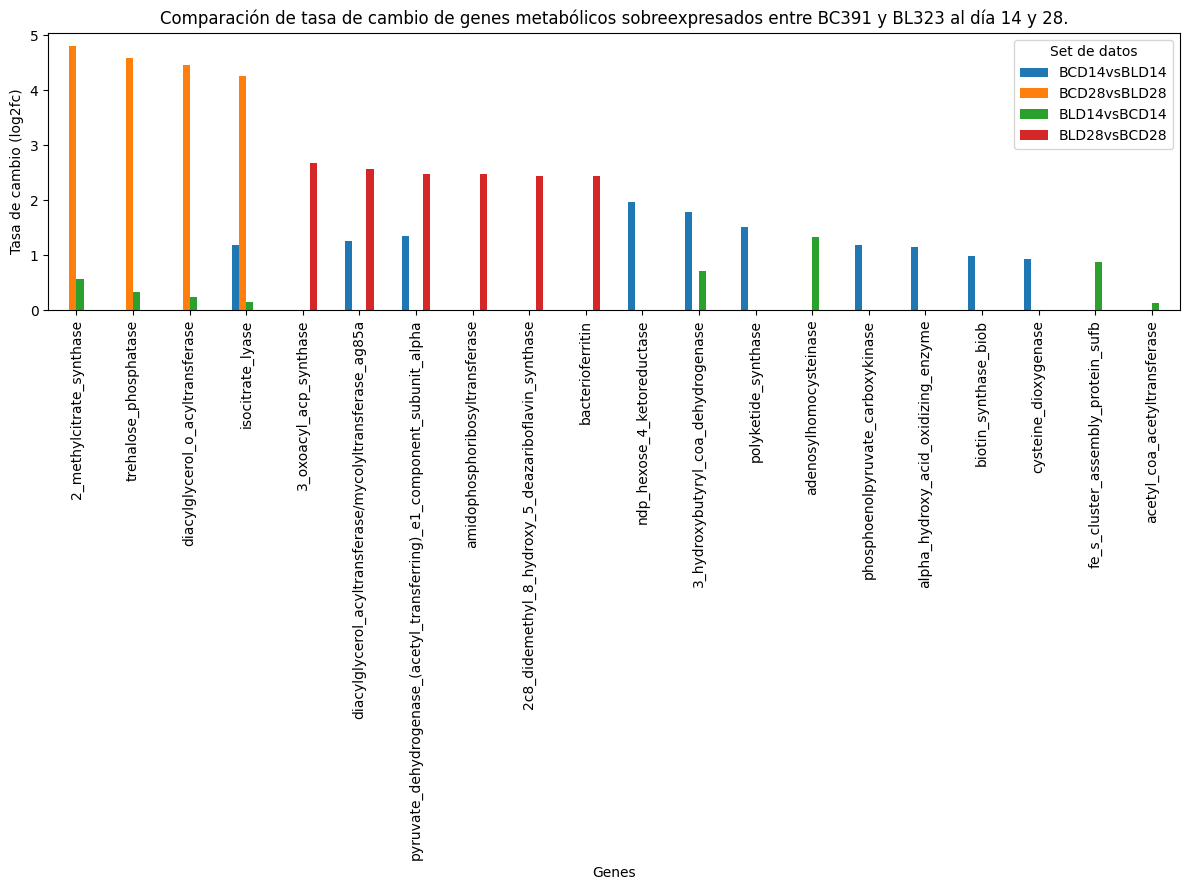

In [148]:
#1er gráfico pero con log2fc
pivot_met_log2fc["sort_key"] = pivot_met_log2fc.max(axis=1)  # Sort by the highest value
pivot_met_log2fc = pivot_met_log2fc.sort_values("sort_key", ascending=False)  # Sort descending
pivot_met_log2fc = pivot_met_log2fc.drop(columns=["sort_key"])  # Drop the helper column

#gráfico
pivot_met_log2fc.plot(kind='bar', figsize=(12, 9)) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio de genes metabólicos sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (log2fc)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

dataset,BCD14vsBLD14,BCD28vsBLD28,BLD14vsBCD14,BLD28vsBCD28
geneproduct,,,,
50s_ribosomal_protein_l13,0.528420,0.000000,0.000000,0.000000
5s_ribosomal_rna,0.000000,0.569803,0.428049,0.000000
adenylyltransferase/sulfurtransferase_moez,0.000000,0.000000,0.216687,0.000000
dna_directed_rna_polymerase_subunit_beta,0.000000,1.412908,0.901590,0.000000
elongation_factor_g,0.471651,0.000000,0.000000,0.000000
is256_family_transposase,0.000000,0.000000,0.000000,0.220933
pe_family_protein,0.000000,0.861569,0.000000,0.000000
rnase_p_rna_component_class_a,0.000000,1.577944,45.914277,0.000000
sam_dependent_methyltransferase,0.000000,0.861569,0.000000,0.000000


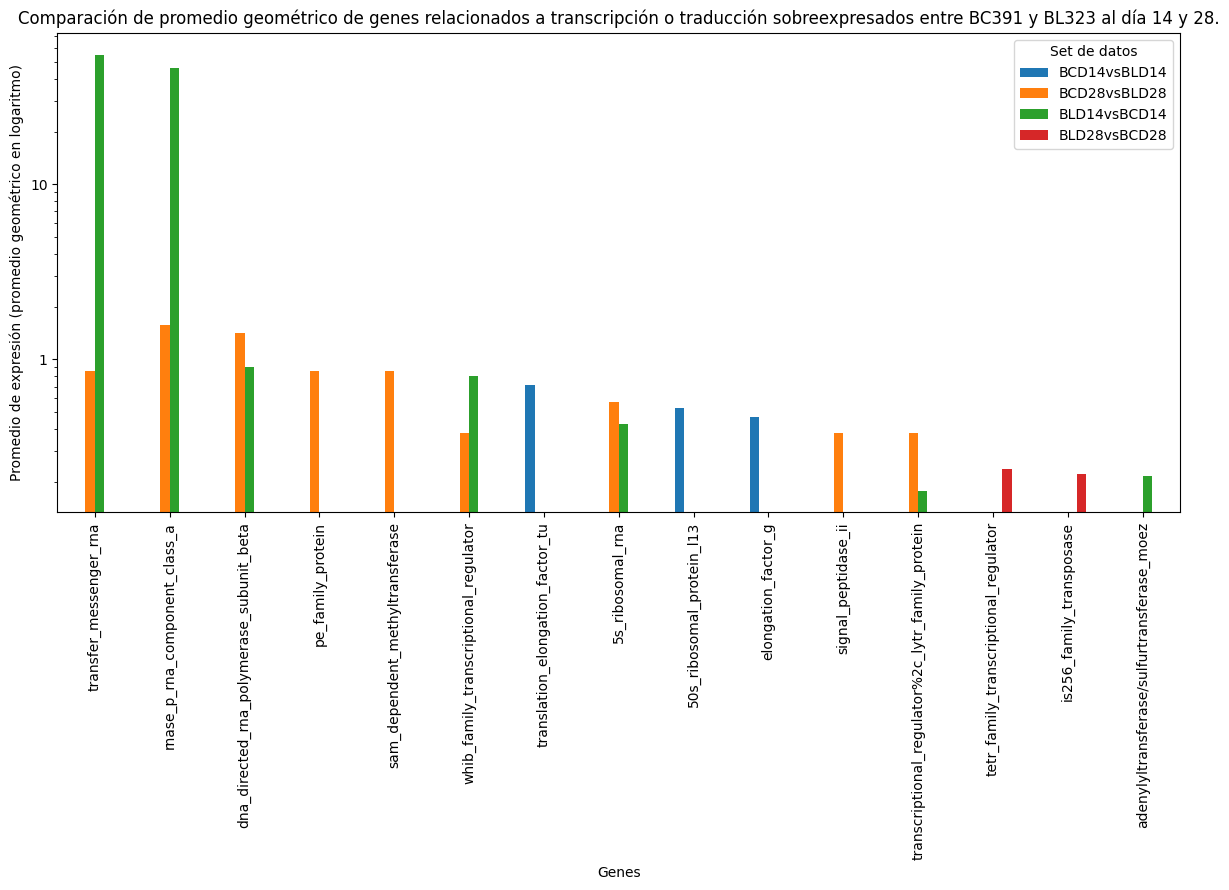

In [149]:
#2do gráfico: trans_trad
#2do gráfico: trans_trad log2fc
pivot_trans_trad = merged_df_trans_trad.pivot(index="geneproduct", columns = "dataset", values= "base_mean")
pivot_trans_trad_log2fc = merged_df_trans_trad.pivot(index="geneproduct", columns = "dataset", values= "log2fc")
pivot_trans_trad = pivot_trans_trad.fillna(0)
pivot_trans_trad_log2fc = pivot_trans_trad_log2fc.fillna(0)
display(pivot_trans_trad)
#display(pivot_trans_trad_log2fc)
#Ordenar los datos 
# Sort rows by the maximum value across datasets
pivot_trans_trad["sort_key"] = pivot_trans_trad.max(axis=1)  # Sort by the highest value
pivot_trans_trad = pivot_trans_trad.sort_values("sort_key", ascending=False)  # Sort descending
pivot_trans_trad = pivot_trans_trad.drop(columns=["sort_key"])  # Drop the helper column
pivot_trans_trad_log2fc["sort_key"] = pivot_trans_trad_log2fc.max(axis=1)  # Sort by the highest value
pivot_trans_trad_log2fc = pivot_trans_trad_log2fc.sort_values("sort_key", ascending=False)  # Sort descending
pivot_trans_trad_log2fc = pivot_trans_trad_log2fc.drop(columns=["sort_key"])  # Drop the helper column

#gráfico
pivot_trans_trad.plot(kind='bar', figsize=(12, 9), logy=True) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedio geométrico de genes relacionados a transcripción o traducción sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico en logaritmo)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()



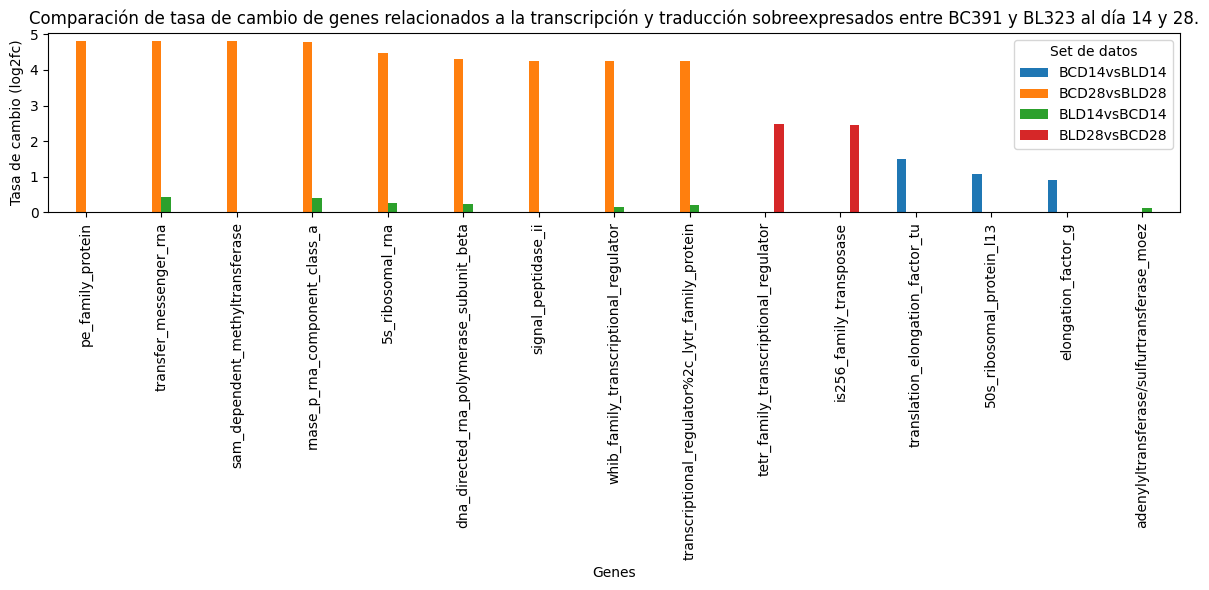

In [153]:
#2do grafico log2fc
pivot_trans_trad_log2fc.plot(kind='bar', figsize=(12, 6)) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio de genes relacionados a la transcripción y traducción sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (log2fc)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

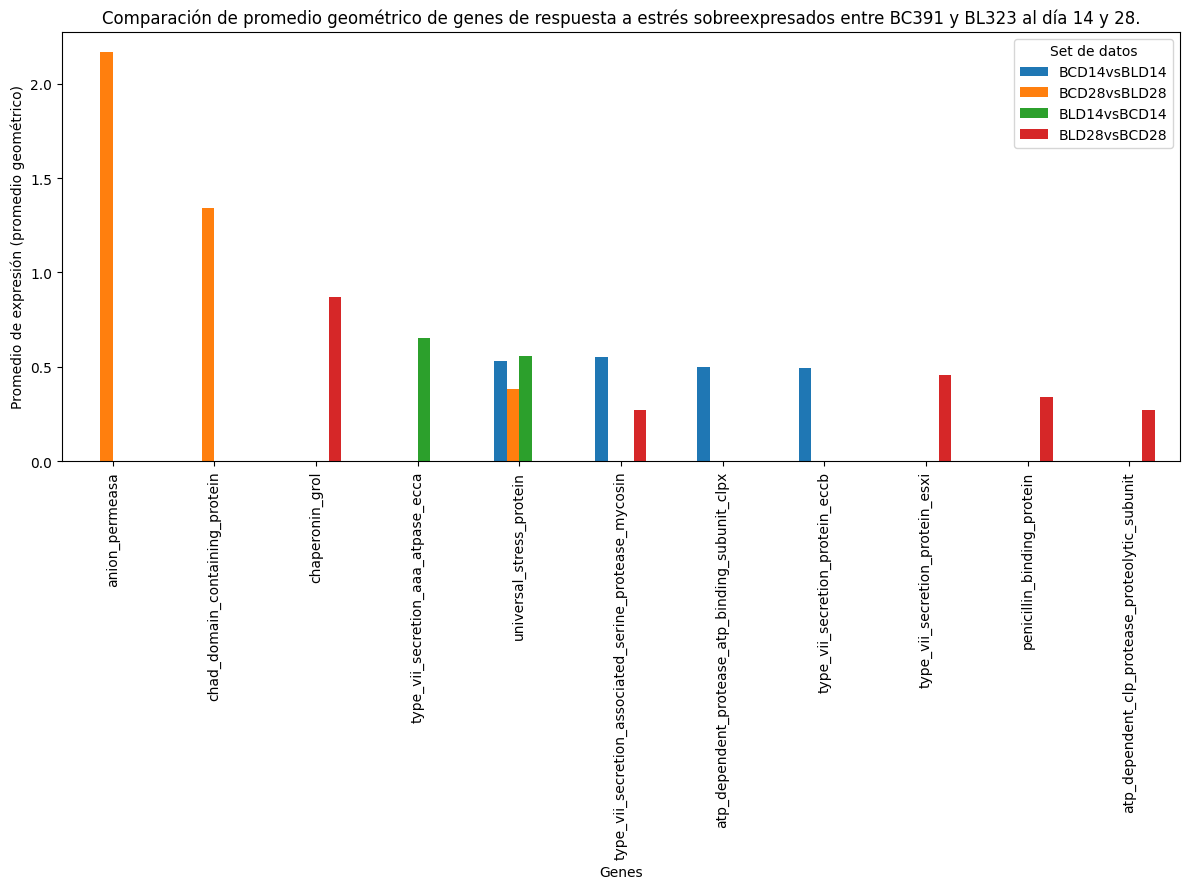

In [151]:
#3er gráfico: estrés
#3er gráfico: estrés log2fc
pivot_estres = merged_df_estres.pivot(index="geneproduct", columns = "dataset", values= "base_mean")
pivot_estres_log2fc = merged_df_estres.pivot(index="geneproduct", columns = "dataset", values= "log2fc")
pivot_estres = pivot_estres.fillna(0)
pivot_estres_log2fc = pivot_estres_log2fc.fillna(0)
#display(pivot_estres)
#display(pivot_estres_log2fc)
#Ordenar los datos 
# Sort rows by the maximum value across datasets
pivot_estres["sort_key"] = pivot_estres.max(axis=1)  # Sort by the highest value
pivot_estres = pivot_estres.sort_values("sort_key", ascending=False)  # Sort descending
pivot_estres = pivot_estres.drop(columns=["sort_key"])  # Drop the helper column
pivot_estres_log2fc["sort_key"] = pivot_estres_log2fc.max(axis=1)  # Sort by the highest value
pivot_estres_log2fc = pivot_estres_log2fc.sort_values("sort_key", ascending=False)  # Sort descending
pivot_estres_log2fc = pivot_estres_log2fc.drop(columns=["sort_key"])  # Drop the helper column

#gráfico
pivot_estres.plot(kind='bar', figsize=(12, 9))#, logy=True) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de promedio geométrico de genes de respuesta a estrés sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Promedio de expresión (promedio geométrico)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

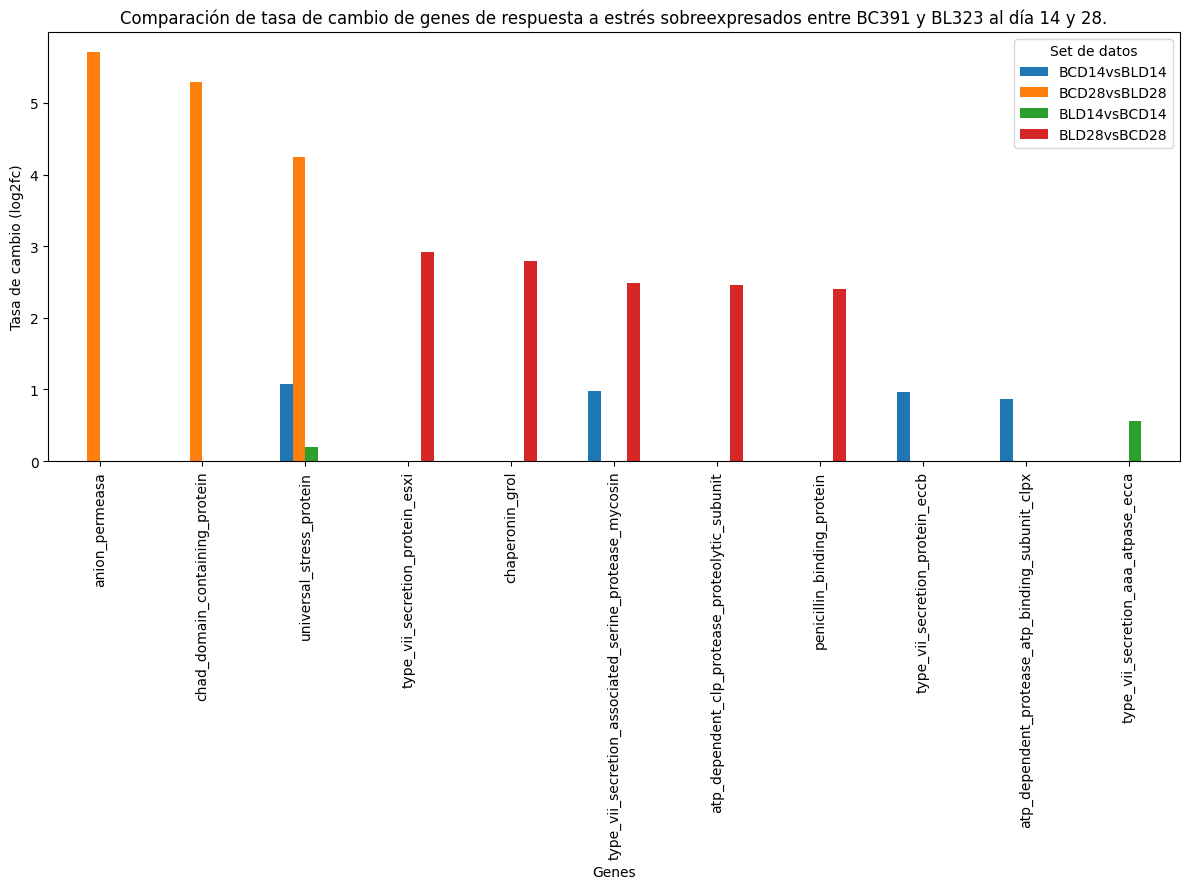

In [152]:
pivot_estres_log2fc.plot(kind='bar', figsize=(12, 9))#, #logy=True) #base mean
#pivot_met_log2fc.plot(kind='bar', figsize=(12, 6), logy=True)
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.title("Comparación de tasa de cambio de genes de respuesta a estrés sobreexpresados entre BC391 y BL323 al día 14 y 28.") #tasa de cambio
plt.xlabel("Genes")
plt.ylabel("Tasa de cambio (log2fc)")
plt.xticks(rotation=90)
plt.legend(title="Set de datos")
plt.tight_layout()

plt.show()

In [ ]:
#Paso 4: generar excel de clasificados

Curiosamente los agrupados también son buenos en python entonces podría hacer una buena exploración y considerar intentar los gráficos de pie en python. Por verse. 